# Libraries

In [ ]:
import os
import sys
import random
import numpy as np
import matplotlib as plt
import traci
import contextlib
import math

Y = "\033[33m"  
E = "\033[0m"  

# Environment

In [ ]:
if 'SUMO_HOME' not in os.environ:
    os.environ['SUMO_HOME'] = '/Library/Frameworks/EclipseSUMO.framework/Versions/1.22.0/EclipseSUMO/share/sumo'

tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
sys.path.append(tools)

@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

def Sumo_init(seed, Visualize=False):
    '''Initialize the SUMO simulation environment.'''
    seed = str(seed)
    if Visualize:
        Sumo_config = [
            '/Library/Frameworks/EclipseSUMO.framework/Versions/1.22.0/EclipseSUMO/bin/sumo-gui',
            '-c', 'SimpleTraci.sumocfg',
            '--no-step-log',
            '--no-warnings',
            '--step-length', '0.1',
            '--delay', '1000',
            '--lateral-resolution', '0.1',
            '--seed', seed,
        ]
    else:
        Sumo_config = [
            '/Library/Frameworks/EclipseSUMO.framework/Versions/1.22.0/EclipseSUMO/bin/sumo',
            '-c', 'SimpleTraci.sumocfg',
            '--no-step-log',
            '--no-warnings',
            '--step-length', '0.1',
            '--delay', '1000',
            '--lateral-resolution', '0.1',
            '--seed', seed,
        ]

    with suppress_output():
        traci.start(Sumo_config)

    return True

In [ ]:
# Initialize queue lengths for each direction
q_EB_0 = 0
q_WB_0 = 0
q_NB_0 = 0

# Current phase of the traffic light
current_phase = 0

# List of detector IDs for monitoring traffic
detector_ids = ["Node4_1_EB_0", "Node4_3_NB_0", "Node4_2_WB_0"]

# ID of the traffic light being controlled
traffic_light_id = "Node4"

# Main Functions

In [ ]:
def get_queue_length(detector_id, velocity_threshold = 0.1): 
    ''' Get the queue length from the detector.'''
    if isinstance(detector_id, list):
        '''Check if we have multiple detectors'''
        total_slow_vehicles = 0
        for det_id in detector_id:
            vehicle_ids = traci.lanearea.getLastStepVehicleIDs(det_id)  
            slow_vehicles = [v for v in vehicle_ids if float(traci.vehicle.getSpeed(v)) <= velocity_threshold]       
            total_slow_vehicles += len(slow_vehicles)  
        return total_slow_vehicles
    else:
        vehicle_ids = traci.lanearea.getLastStepVehicleIDs(detector_id) 
        slow_vehicles = [v for v in vehicle_ids if float(traci.vehicle.getSpeed(v)) <= velocity_threshold]         
        queue_lenght = len(slow_vehicles)
        return queue_lenght


def get_current_phase(traffic_light_id):
    ''' Get the current traffic light phase.'''
    current_phase = traci.trafficlight.getPhase(traffic_light_id)
    return current_phase

def get_state(detector_ids, traffic_light_id):
    ''' Get the current state of the environment, including queue lenghts and current light phase.'''
    queue_lenghts  = [get_queue_length(det) for det in detector_ids]
    current_phase = get_current_phase(traffic_light_id)
    state = tuple(queue_lenghts + [current_phase])
    return state

def calculate_reward(state):
    '''Calculate the reward based on the negative sum of the queue lengths. '''
    total_queue = sum(state[:-1])  
    reward = -float(total_queue)
    return reward
  
def moving_average(data, window_size):
    '''Calculate the moving average of a given data array.'''
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Fixed Times

In [ ]:
def run_fixed_time_simulation(TOTAL_STEPS, detector_ids, traffic_light_id, Verbose = False):
    '''Run the fixed time simulation for traffic light control.'''

    cumulative_reward = 0.0
    step_history = []
    reward_history = []
    queue_history = []
    average_queue_lenght_for_step_history = []
    
    try: 
        for step in range(TOTAL_STEPS):
            state = get_state(detector_ids, traffic_light_id)
            traci.simulationStep()
            new_state = get_state(detector_ids, traffic_light_id)       
            reward = calculate_reward(new_state)
            cumulative_reward += reward
            
            reward_history.append(reward)
            step_history.append(step)
            queue_lengths = [get_queue_length(det) for det in detector_ids]
            queue_history.append(queue_lengths)   
            average_queue_lenght_for_step = sum(queue_lengths) / len(queue_lengths) if queue_lengths else 0
            average_queue_lenght_for_step_history.append(average_queue_lenght_for_step)
            queue_history.append(queue_lengths)        
            
            if Verbose:
                if step % 100 == 0:
                    print(f"Step {step}, Current_State: {state}, New_State: {new_state}, Reward: {reward:.2f}, Cumulative Reward: {cumulative_reward:.2f}")

        average_queue_length = np.mean([sum(q) if isinstance(q, (list, tuple)) else q for q in queue_history])
        print(f"{Y}Cumulative Reward: {cumulative_reward:.2f}, average queue length: {average_queue_length:.2f}{E}")

    except KeyboardInterrupt:
        print(f"{Y}Simulation interrupted by user.{E}")
    
    finally:
        if traci.isLoaded():
            traci.close()
    
    return step_history, reward_history, queue_history, average_queue_lenght_for_step_history, cumulative_reward, average_queue_length

In [ ]:
average_reward_FT = []
average_queue_length_on_seeds_FT = []
all_rewards_FT = []
all_queues_FT = []

for i in range(10,20):
    print(f"{Y}Running simulation with seed {i}{E}")
    Sumo_init(i)
    step_history_FT, reward_history_FT, queue_history_FT, average_queue_length_for_step_history_FT, cumulative_reward_FT, average_queue_length_FT = run_fixed_time_simulation(20000, detector_ids, traffic_light_id,  Verbose = False)
    average_reward_FT.append(cumulative_reward_FT)
    average_queue_length_on_seeds_FT.append(average_queue_length_FT)
    print('--' * 50)
    all_queues_FT.extend(average_queue_length_for_step_history_FT)
    all_rewards_FT.extend(reward_history_FT)

print(f"{Y}Average Cumulative Reward over 10 runs: {np.mean(average_reward_FT):.2f}, Standard Deviation: {np.std(average_reward_FT):.2f}{E}")
print(f"{Y}Average Queue Length over 10 runs: {np.mean(average_queue_length_on_seeds_FT):.2f}{E}")

Running simulation with seed 10


Cumulative Reward: -47659.00, average queue length: 2.38
----------------------------------------------------------------------------------------------------
Running simulation with seed 11


Cumulative Reward: -53727.00, average queue length: 2.69
----------------------------------------------------------------------------------------------------
Running simulation with seed 12


Cumulative Reward: -52488.00, average queue length: 2.62
----------------------------------------------------------------------------------------------------
Running simulation with seed 13


Cumulative Reward: -43094.00, average queue length: 2.15
----------------------------------------------------------------------------------------------------
Running simulation with seed 14


Cumulative Reward: -50941.00, average queue length: 2.55
----------------------------------------------------------------------------------------------------
Running simulation with seed 15


Cumulative Reward: -49496.00, average queue length: 2.47
----------------------------------------------------------------------------------------------------
Running simulation with seed 16


Cumulative Reward: -54220.00, average queue length: 2.71
----------------------------------------------------------------------------------------------------
Running simulation with seed 17


Cumulative Reward: -50496.00, average queue length: 2.52
----------------------------------------------------------------------------------------------------
Running simulation with seed 18


Cumulative Reward: -59551.00, average queue length: 2.98
----------------------------------------------------------------------------------------------------
Running simulation with seed 19


Cumulative Reward: -51287.00, average queue length: 2.56
----------------------------------------------------------------------------------------------------
Average Cumulative Reward over 10 runs: -51295.90, Standard Deviation: 4105.27
Average Queue Length over 10 runs: 2.56


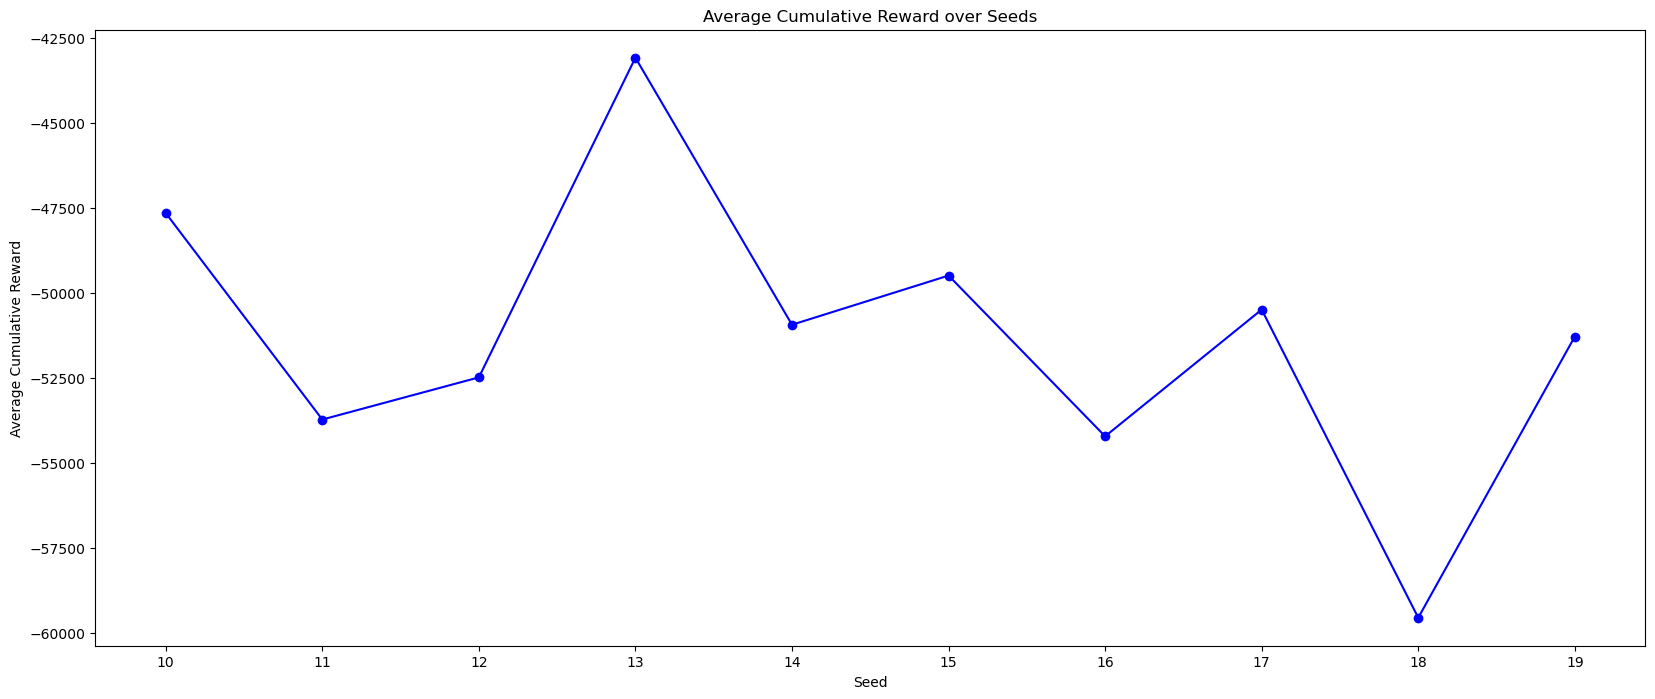

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(range(10, 20), average_reward_FT, marker='o', color='blue', label='Average Cumulative Reward')
plt.title('Average Cumulative Reward over Seeds')
plt.xlabel('Seed')
plt.ylabel('Average Cumulative Reward')
plt.xticks(range(10, 20))
plt.savefig('average_cumulative_reward_over_seeds.png')

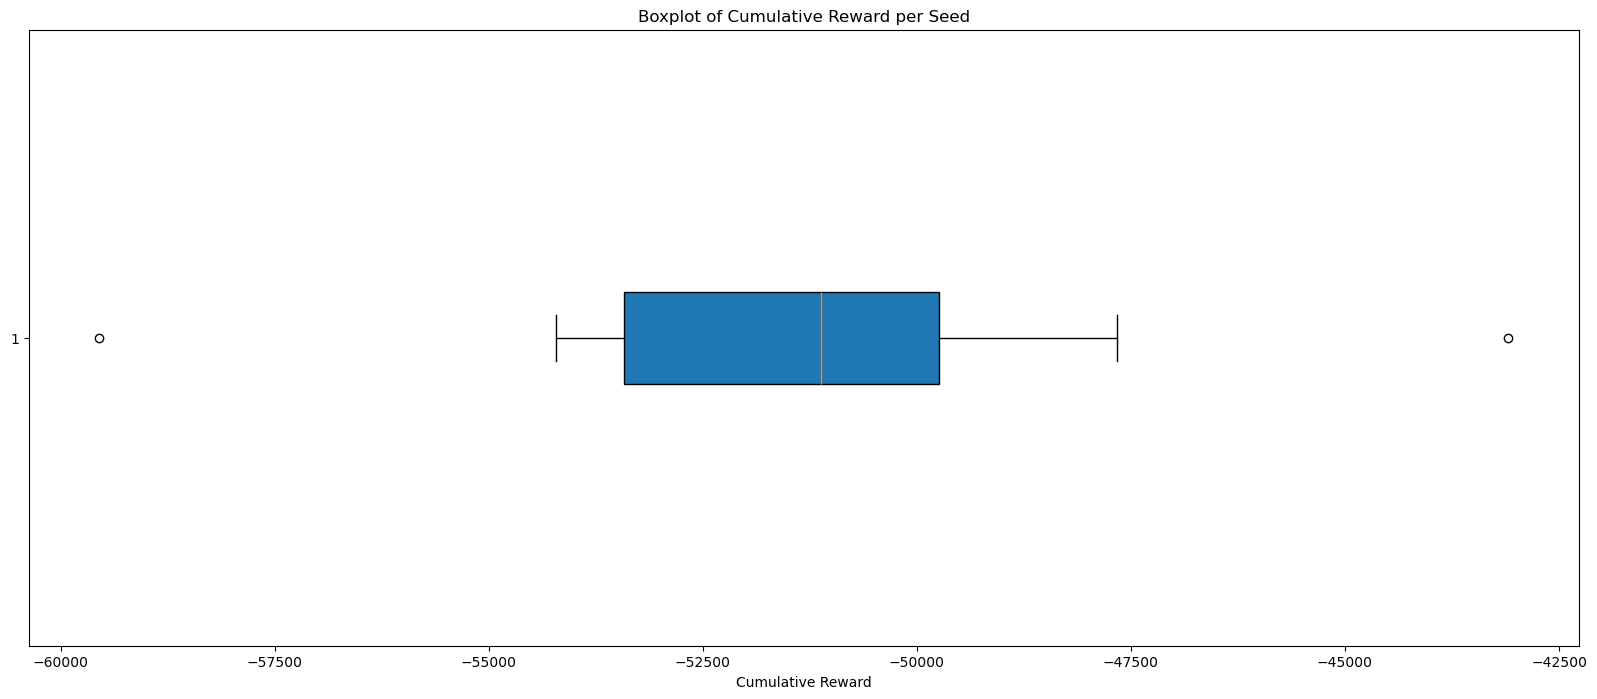

In [ ]:
plt.figure(figsize=(20, 8))
plt.boxplot(average_reward_FT, vert=False, patch_artist=True)
plt.title('Boxplot of Cumulative Reward per Seed')
plt.xlabel('Cumulative Reward')
plt.savefig('boxplot_cumulative_reward_per_seed.png')


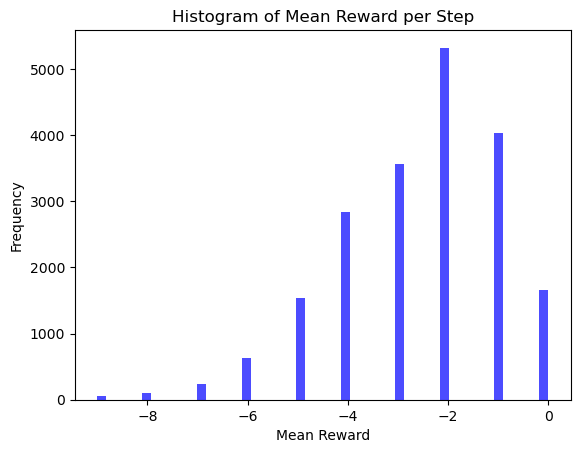

In [ ]:
plt.hist(reward_history_FT, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Mean Reward per Step')
plt.xlabel('Mean Reward')
plt.ylabel('Frequency')
plt.savefig('histogram_mean_reward_per_step.png')


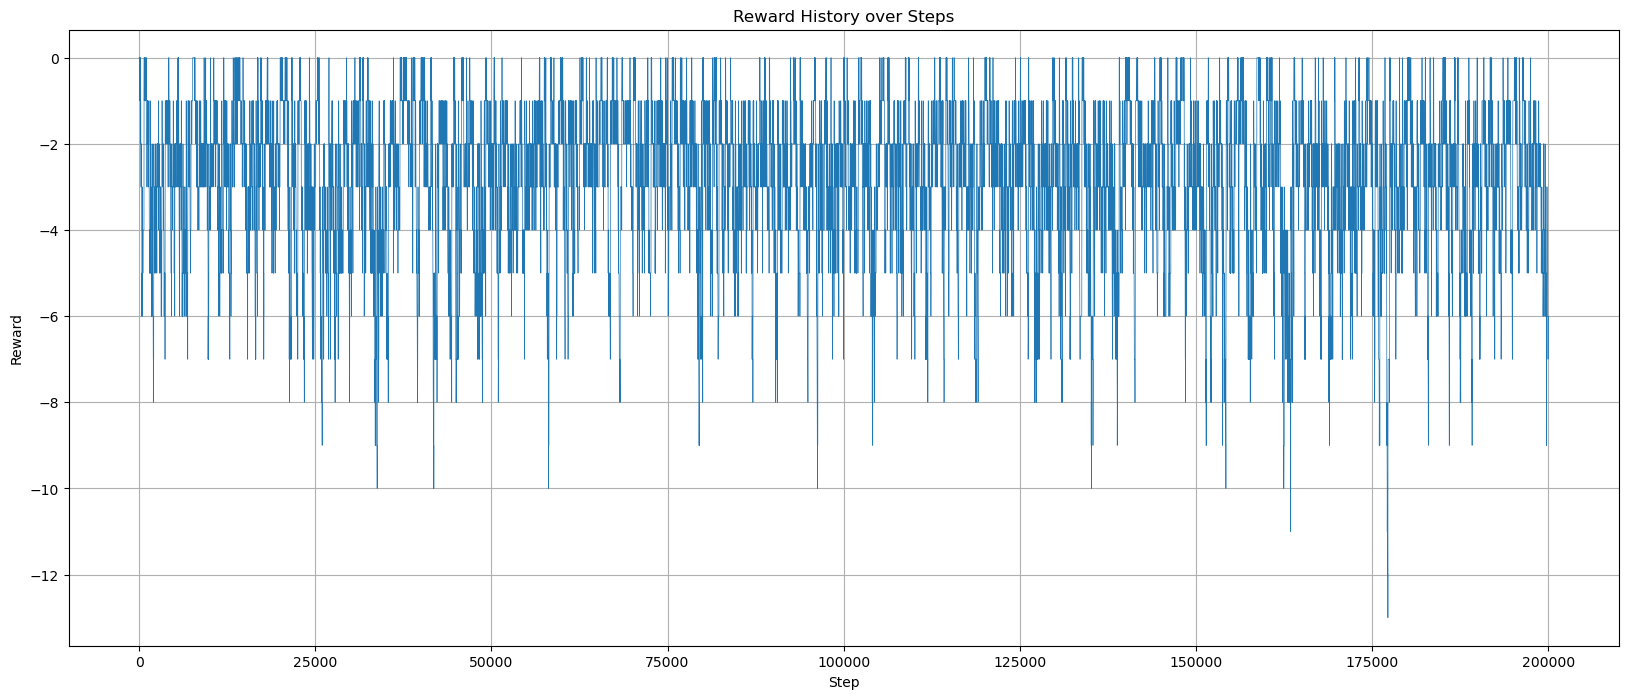

In [ ]:
steps = list(range(len(all_rewards_FT)))

plt.figure(figsize=(20, 8))
plt.plot(steps, all_rewards_FT, linewidth=0.5)
plt.title('Reward History over Steps')
plt.xlabel('Step')
plt.ylabel('Reward')
plt.grid()
plt.savefig('reward_history_over_steps.png')


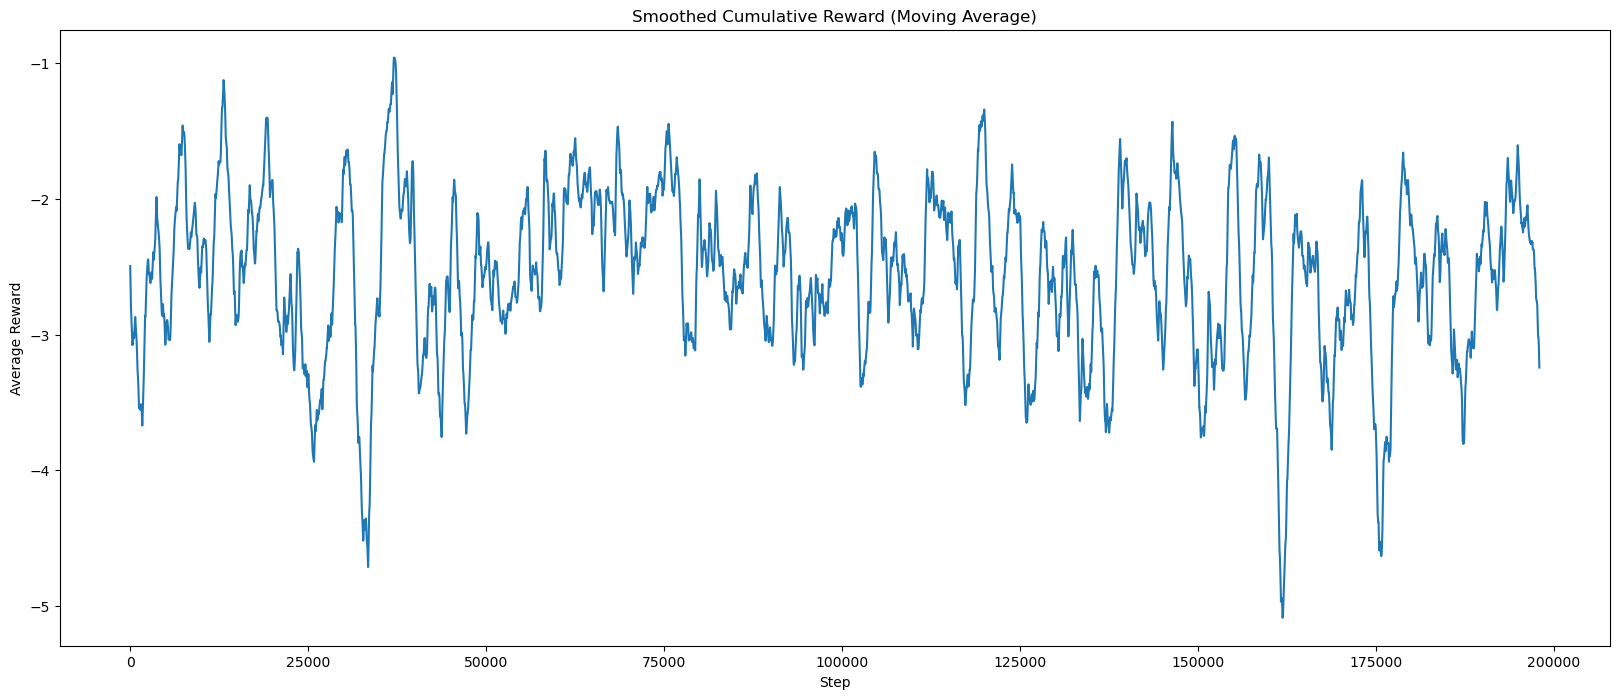

In [ ]:
ma_rewards = moving_average(all_rewards_FT, 2000)

plt.figure(figsize=(20, 8))
plt.plot(ma_rewards)
plt.title("Smoothed Cumulative Reward (Moving Average)")
plt.xlabel("Step")
plt.ylabel("Average Reward")
plt.savefig("smoothed_reward_over_all_steps.png")

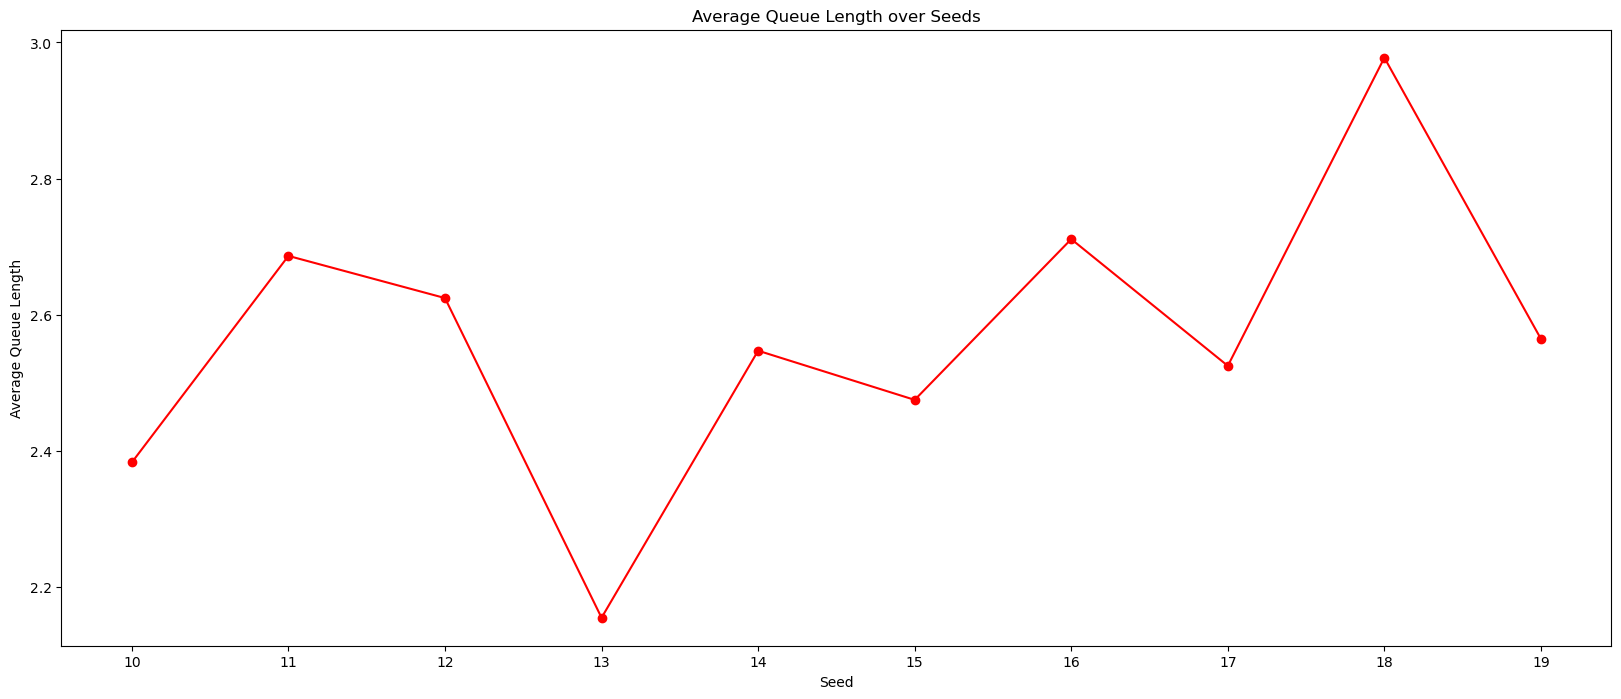

In [47]:
plt.figure(figsize=(20, 8))
plt.plot(range(10, 20), average_queue_length_on_seeds_FT, marker='o', color='red', label='Average Queue Length')
plt.title('Average Queue Length over Seeds')
plt.xlabel('Seed')
plt.ylabel('Average Queue Length')
plt.xticks(range(10, 20))
plt.savefig('average_queue_length_over_seeds.png')

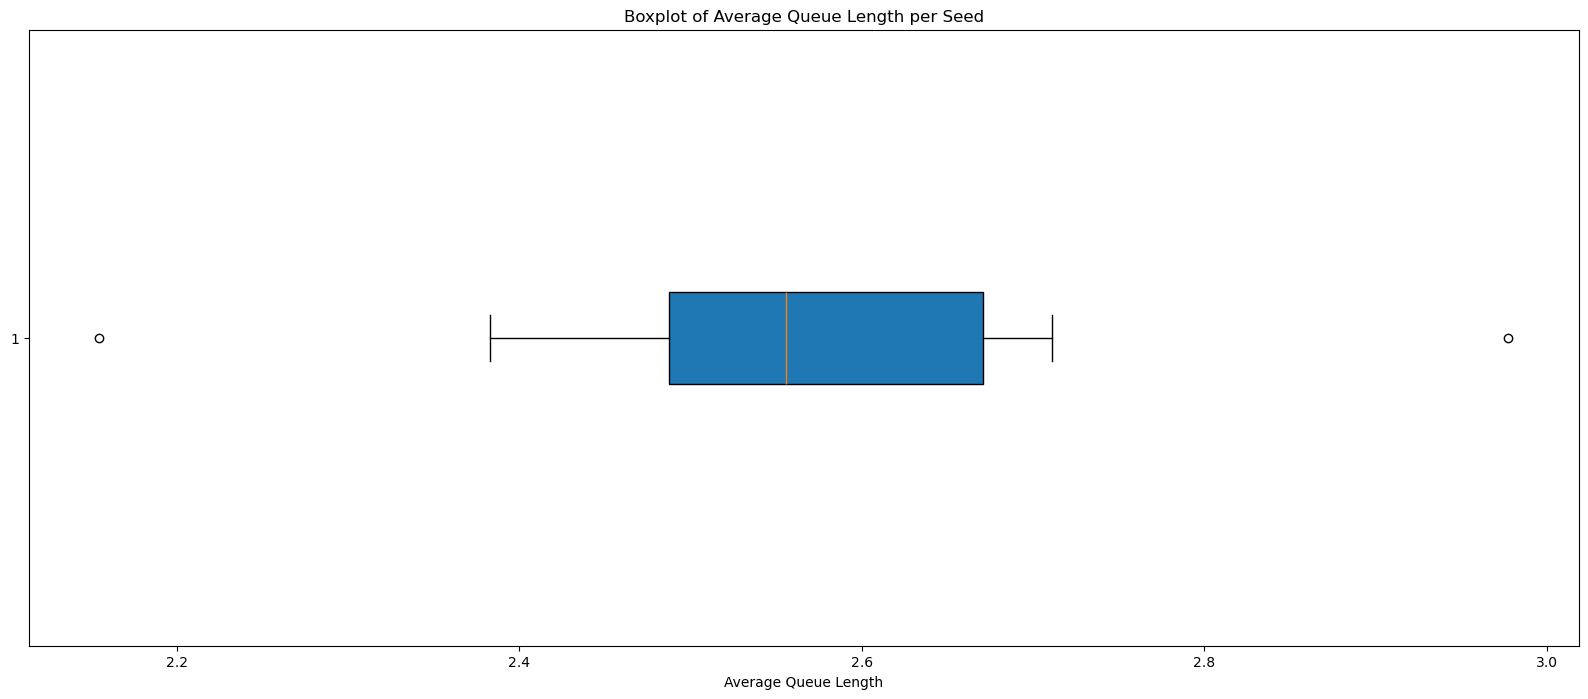

In [ ]:
plt.figure(figsize=(20, 8))
plt.boxplot(average_queue_length_on_seeds_FT, vert=False, patch_artist=True)
plt.title('Boxplot of Average Queue Length per Seed')
plt.xlabel('Average Queue Length')
plt.savefig('boxplot_average_queue_length_per_seed.png')


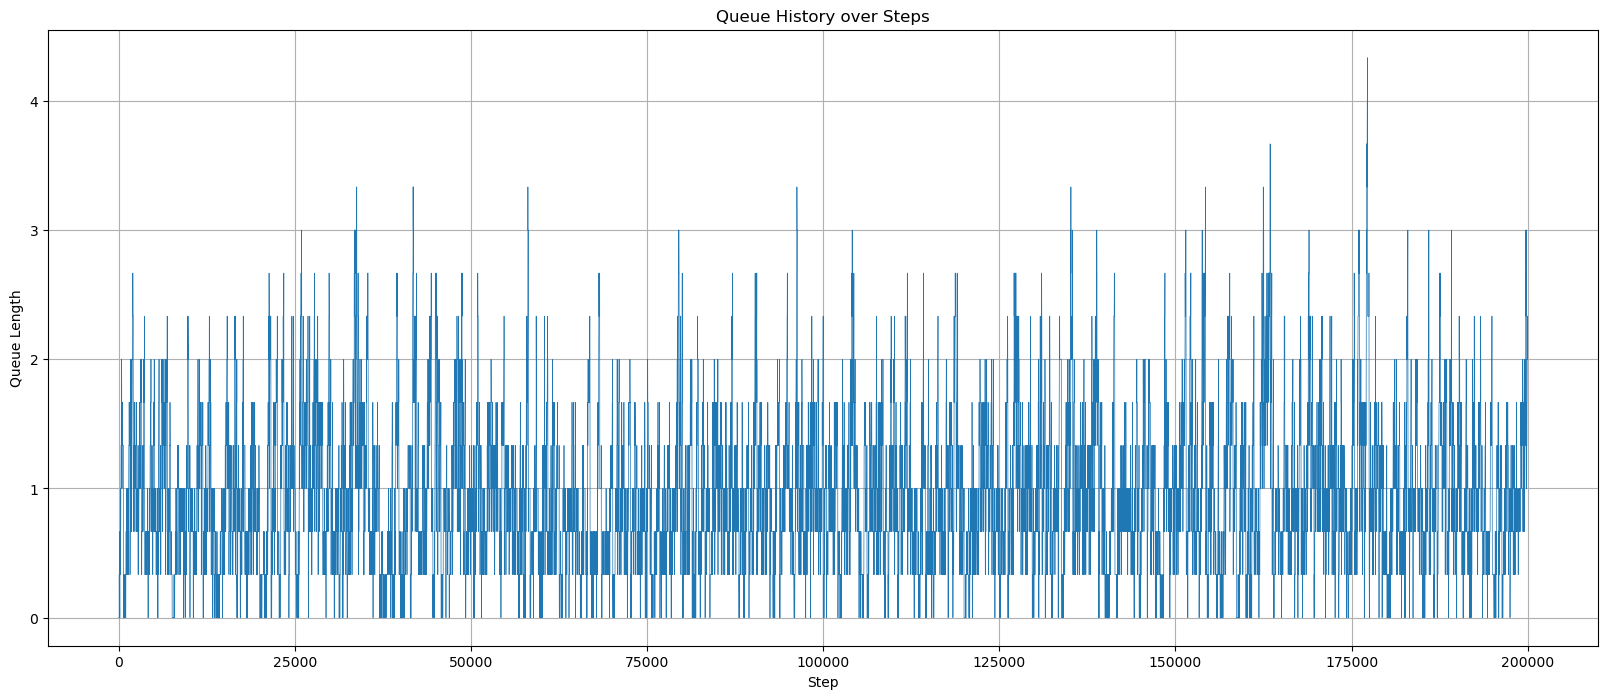

In [ ]:
steps = list(range(len(all_queues_FT)))

plt.figure(figsize=(20, 8))
plt.plot(steps, all_queues_FT, linewidth=0.5)
plt.title('Queue History over Steps')
plt.xlabel('Step')
plt.ylabel('Queue Length')
plt.grid()
plt.savefig('reward_history_over_steps.png')

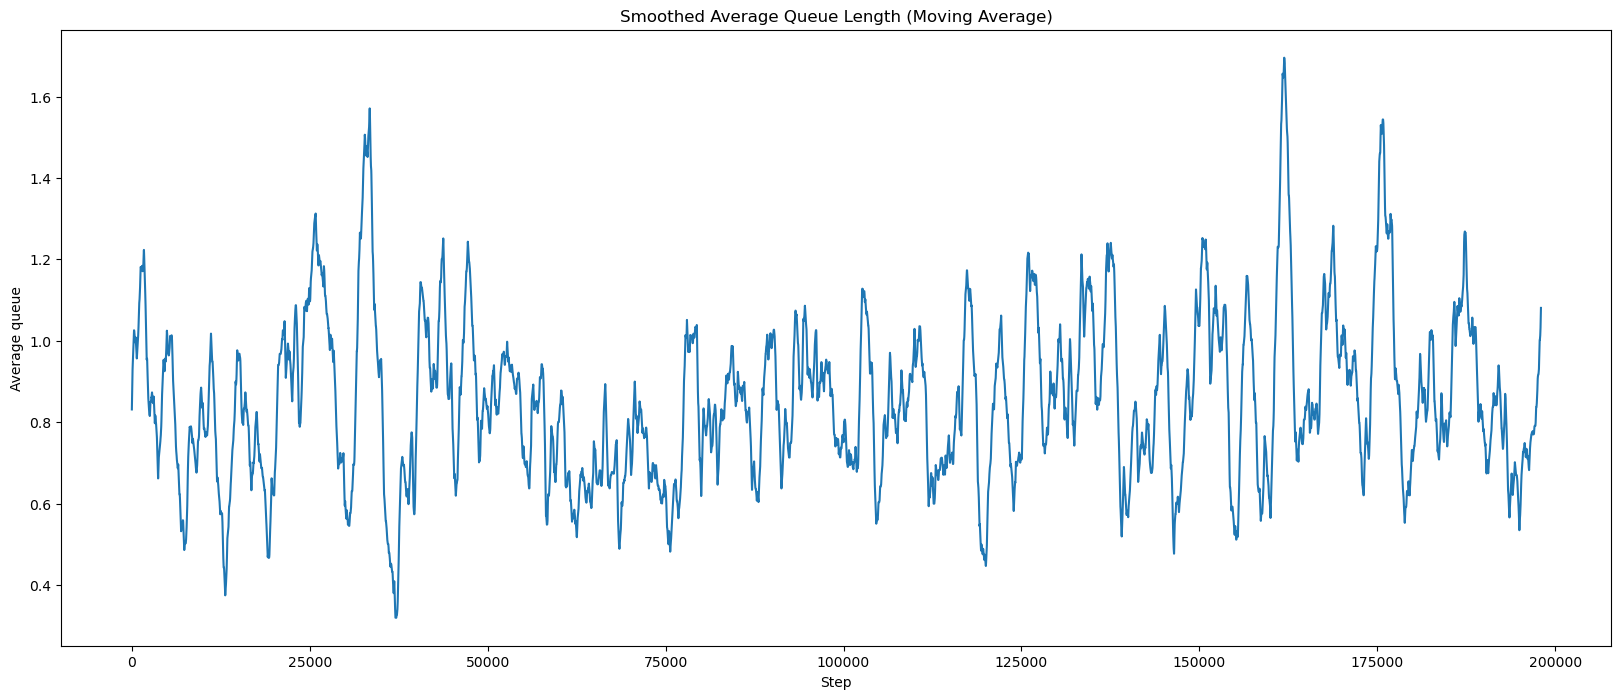

In [ ]:
ma_queues = moving_average(all_queues_FT, 2000)

plt.figure(figsize=(20, 8))
plt.plot(ma_queues)
plt.title("Smoothed Average Queue Length (Moving Average)")
plt.xlabel("Step")
plt.ylabel("Average queue")
plt.savefig("smoothed_reward_over_all_steps.png")

# Q - Learning

In [ ]:
# Define possible actions for the traffic light control
ACTIONS = [0,1,2]

# Define the phases corresponding to the actions
PHASES = [0,2,4]

# Number of possible actions
NUM_ACTIONS = len(ACTIONS)

# Initialize the Q-table for Q-learning
# The Q-table maps state-action pairs to their corresponding Q-values
Q_table = {(0,0,0,0) : np.zeros(NUM_ACTIONS)}

In [ ]:
def get_action_from_policy(state, EPSILON): 
    '''Balance exploration and exploitation.'''
    if state not in Q_table:
        Q_table[state] = np.zeros(NUM_ACTIONS)
        return int(random.choice(ACTIONS))
    if random.random() < EPSILON:
        return int(random.choice(ACTIONS))
    max_value = np.max(Q_table[state])
    max_indices = np.flatnonzero(Q_table[state] == max_value)
    return int(np.random.choice(max_indices))

last_switch_step = 0  

def apply_action(current_step, current_phase, MIN_GREEN_STEPS=100):
    '''Check if we can apply an action'''
    global last_switch_step
    if current_step - last_switch_step < MIN_GREEN_STEPS:  
        return False        
    if current_phase % 2 == 1:
        return False
    return True

def cosine_decay_epsilon(t, T_max, eps_max=1.0, eps_min=0.01):
    '''Calculate epsilon using cosine decay.'''
    cosine = math.cos(math.pi * t / T_max)
    return eps_min + 0.5 * (eps_max - eps_min) * (1 + cosine)

def update_Q_table(old_state, action_idx, reward, new_state, ALPHA=0.1, GAMMA=0.95):
    ''' Update the Q-table using the Q-learning update rule.'''
    if old_state not in Q_table:
        Q_table[old_state] = np.zeros(NUM_ACTIONS)
    if new_state not in Q_table:
        Q_table[new_state] = np.zeros(NUM_ACTIONS)
        
    Q_table[old_state][action_idx] = Q_table[old_state][action_idx] + ALPHA * (reward + GAMMA * np.max(Q_table[new_state]) - Q_table[old_state][action_idx])

In [ ]:
def run_Q_learning_simulation(TOTAL_STEPS, detector_ids, traffic_light_id, EPSILON, training=True, Verbose= False, global_step=0):
    '''Run the Q-learning simulation for traffic light control.'''
    global last_switch_step

    cumulative_reward = 0.0
    step_history = []
    reward_history = []
    queue_history = []
    average_queue_length_for_step_history = []
    last_switch_step = 0.0
    step = 0

    try:
        while step < TOTAL_STEPS:
            state = get_state(detector_ids, traffic_light_id)
            action_idx = get_action_from_policy(state, EPSILON)
            phase_code = PHASES[action_idx]
            current_phase = state[-1]  
            action_applied = apply_action(step, current_phase)

            if action_applied:
                if phase_code != current_phase:  
                    current_phase = current_phase + 1        
                    traci.trafficlight.setPhase(traffic_light_id, current_phase)  
                    
                    for _ in range(30):
                        traci.simulationStep()
                        step += 1
                        new_state = get_state(detector_ids, traffic_light_id)
                        reward = calculate_reward(new_state)
                        cumulative_reward += reward
                        
                        reward_history.append(reward)
                        step_history.append(step)
                        queue_lengths = [get_queue_length(det) for det in detector_ids]
                        queue_history.append(queue_lengths)
                        average_queue_length_for_step = sum(queue_lengths) / len(queue_lengths) if queue_lengths else 0
                        average_queue_length_for_step_history.append(average_queue_length_for_step)

                    traci.trafficlight.setPhase(traffic_light_id, phase_code)
                    last_switch_step = step

                traci.simulationStep()
                step += 1
                new_state = get_state(detector_ids, traffic_light_id)
                reward = calculate_reward(new_state)

                if training:
                    update_Q_table(state, action_idx, reward, new_state)
            else: 
                traci.simulationStep()
                step += 1
                new_state = get_state(detector_ids, traffic_light_id)
                reward = calculate_reward(new_state)
                
            if training:
                EPSILON = cosine_decay_epsilon(global_step + step, TOTAL_STEPS*10, eps_max=1.0, eps_min=0.01)

            step_history.append(step)
            cumulative_reward += reward
            reward_history.append(reward)
            queue_lengths = [get_queue_length(det) for det in detector_ids]
            queue_history.append(queue_lengths)
            average_queue_length_for_step = sum(queue_lengths) / len(queue_lengths) if queue_lengths else 0
            average_queue_length_for_step_history.append(average_queue_length_for_step)

            if Verbose == True:
                if step % 100 == 0:
                    print(f"{Y}Step {step}/{TOTAL_STEPS}, Epsilon: {EPSILON:.4f}, Cumulative Reward: {cumulative_reward:.2f}{E}, Queue Lengths: {new_state[:3]}, Action: {action_idx}")

        average_queue_length = np.mean([sum(q) if isinstance(q, (list, tuple)) else q for q in queue_history])
        print(f"{Y}Cumulative Reward: {cumulative_reward:.2f}, Average Queue Length: {average_queue_length:.2f}{E}, Epsilon: {EPSILON:.4f}")

    except KeyboardInterrupt:
        print(f"{Y}Simulation interrupted by user.{E}")
    
    finally:
        if traci.isLoaded():
            traci.close()

    if training:
        return  reward_history, average_queue_length_for_step_history, cumulative_reward, average_queue_length, EPSILON, step

    return step_history, reward_history, queue_history, average_queue_length_for_step_history, cumulative_reward, average_queue_length, EPSILON, step

## Training

In [ ]:
EPSILON = 1.0
global_step = 0
average_reward_Q_training = []
average_queue_length_on_seeds_Q_training = []
all_queues_Q_training = []
all_rewards_Q_training = []

for i in range(10):
    print(f"{Y}Running simulation with seed {i}{E}")
    Sumo_init(i)
    reward_history_Q_training, average_queue_length_for_step_history_Q_training, cumulative_reward_Q_training, average_queue_length_Q_training, EPSILON, step_run = run_Q_learning_simulation(80000, detector_ids, traffic_light_id, EPSILON=EPSILON, training=True, Verbose=False, global_step=global_step)
    global_step += step_run
    all_queues_Q_training.extend(average_queue_length_for_step_history_Q_training)
    all_rewards_Q_training.extend(reward_history_Q_training)
    average_reward_Q_training.append(cumulative_reward_Q_training)
    average_queue_length_on_seeds_Q_training.append(average_queue_length_Q_training)
    print('--' * 50)

Running simulation with seed 0


Cumulative Reward: -215199.00, Average Queue Length: 2.69, Epsilon: 0.9758
----------------------------------------------------------------------------------------------------
Running simulation with seed 1


Cumulative Reward: -191079.00, Average Queue Length: 2.39, Epsilon: 0.9055
----------------------------------------------------------------------------------------------------
Running simulation with seed 2


Cumulative Reward: -181122.00, Average Queue Length: 2.26, Epsilon: 0.7959
----------------------------------------------------------------------------------------------------
Running simulation with seed 3


Cumulative Reward: -189390.00, Average Queue Length: 2.37, Epsilon: 0.6580
----------------------------------------------------------------------------------------------------
Running simulation with seed 4


Cumulative Reward: -143674.00, Average Queue Length: 1.80, Epsilon: 0.5050
----------------------------------------------------------------------------------------------------
Running simulation with seed 5


Cumulative Reward: -124261.00, Average Queue Length: 1.55, Epsilon: 0.3520
----------------------------------------------------------------------------------------------------
Running simulation with seed 6


Cumulative Reward: -124944.00, Average Queue Length: 1.56, Epsilon: 0.2140
----------------------------------------------------------------------------------------------------
Running simulation with seed 7


Cumulative Reward: -117846.00, Average Queue Length: 1.47, Epsilon: 0.1045
----------------------------------------------------------------------------------------------------
Running simulation with seed 8


Cumulative Reward: -103577.00, Average Queue Length: 1.29, Epsilon: 0.0342
----------------------------------------------------------------------------------------------------
Running simulation with seed 9


Cumulative Reward: -95115.00, Average Queue Length: 1.19, Epsilon: 0.0100
----------------------------------------------------------------------------------------------------


In [15]:
print(f"{Y}Final Q-table:{E}")
for state, actions in Q_table.items():
    print(f"State {state}: {actions}")

Final Q-table:
State (0, 0, 0, 0): [-1.00683196 -0.88924818 -1.09254908]
State (0, 0, 1, 0): [-0.10191799 -0.02469061 -0.21118213]
State (0, 1, 0, 0): [-1.66249713 -1.0165664  -1.97038918]
State (0, 0, 0, 2): [-1.04868932 -0.92285279 -0.9469745 ]
State (0, 1, 0, 2): [-0.18763241 -0.16192994 -0.1365372 ]
State (0, 0, 1, 2): [-0.98110379 -1.76523486 -2.28416699]
State (0, 0, 2, 2): [-1.78226965 -2.99441314 -3.3531852 ]
State (1, 0, 1, 2): [-2.65116338 -4.02195624 -2.2978273 ]
State (1, 0, 0, 0): [-1.45706831 -2.27958731 -0.96553471]
State (1, 1, 0, 0): [-3.96427851 -2.18649081 -2.55656821]
State (1, 0, 1, 0): [ 0.       -0.194349  0.      ]
State (2, 0, 0, 0): [-2.3666108  -3.06690788 -1.48319672]
State (2, 0, 1, 0): [0. 0. 0.]
State (2, 1, 0, 0): [-4.36154317 -3.09141807 -2.25225835]
State (2, 0, 0, 2): [-3.73671021 -2.94476179 -1.42512463]
State (2, 1, 0, 2): [ 0.          0.         -0.10554647]
State (2, 0, 1, 2): [-3.10174631 -4.20064876 -2.50767834]
State (2, 0, 2, 2): [-2.28154108

In [ ]:
print(f"{Y}Final Q-table shape: {len(Q_table)} states, {NUM_ACTIONS} actions per state.{E}")

Final Q-table shape: 464 states, 3 actions per state.


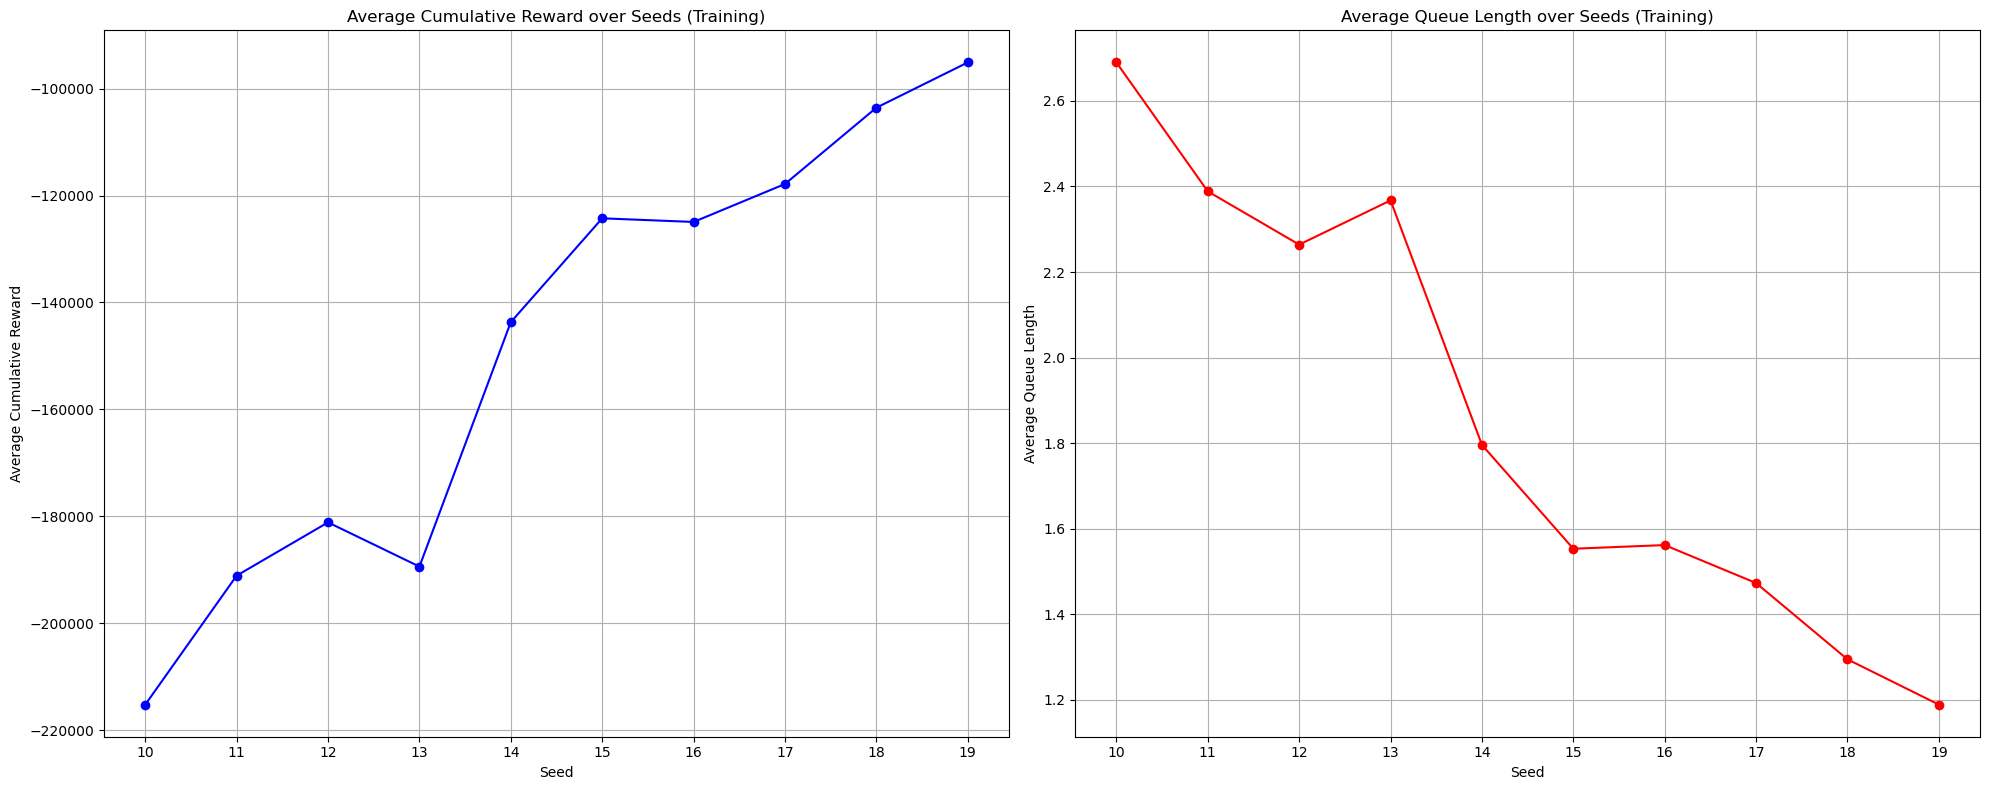

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8)) 

axes[0].plot(range(10, 20), average_reward_Q_training, marker='o', color='blue', label='Average Cumulative Reward')
axes[0].set_title('Average Cumulative Reward over Seeds (Training)')
axes[0].set_xlabel('Seed')
axes[0].set_ylabel('Average Cumulative Reward')
axes[0].set_xticks(range(10, 20))
axes[0].grid(True)

axes[1].plot(range(10, 20), average_queue_length_on_seeds_Q_training, marker='o', color='red', label='Average Queue Length')
axes[1].set_title('Average Queue Length over Seeds (Training)')
axes[1].set_xlabel('Seed')
axes[1].set_ylabel('Average Queue Length')
axes[1].set_xticks(range(10, 20))
axes[1].grid(True)

plt.tight_layout()
plt.savefig('comparison_over_seeds.png')
plt.show()

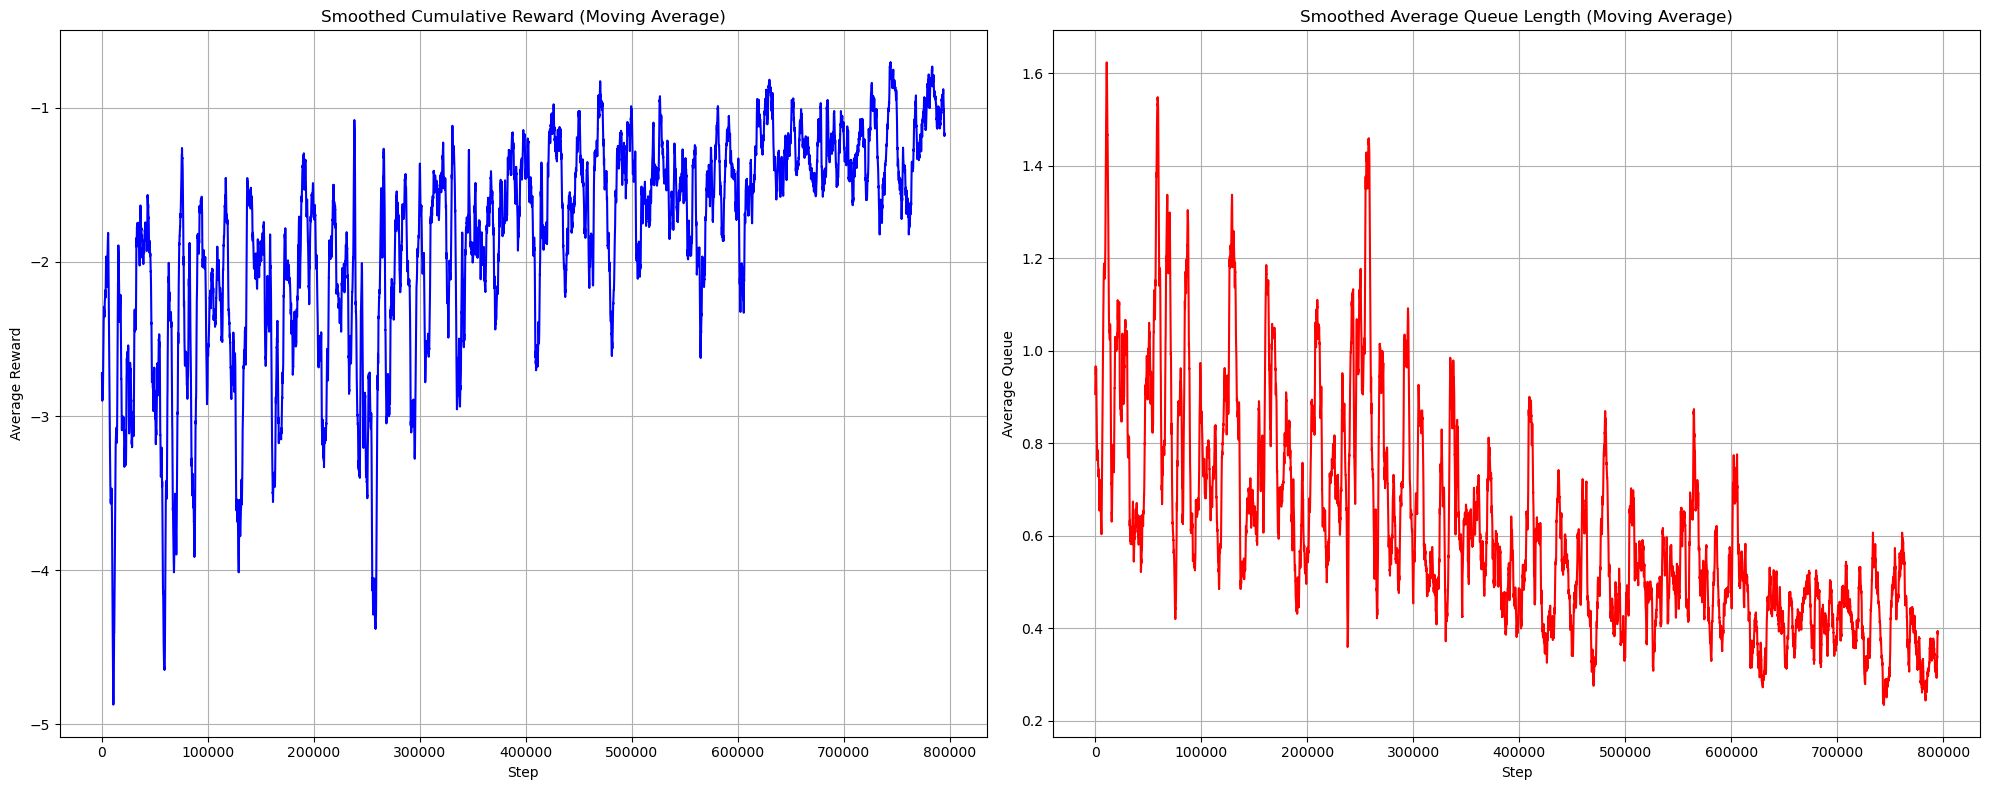

In [ ]:
ma_rewards = moving_average(all_rewards_Q_training, 5000)
ma_queues = moving_average(all_queues_Q_training, 5000)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

axes[0].plot(ma_rewards, color='blue')
axes[0].set_title("Smoothed Cumulative Reward (Moving Average)")
axes[0].set_xlabel("Step")
axes[0].set_ylabel("Average Reward")
axes[0].grid(True)

axes[1].plot(ma_queues, color='red')
axes[1].set_title("Smoothed Average Queue Length (Moving Average)")
axes[1].set_xlabel("Step")
axes[1].set_ylabel("Average Queue")
axes[1].grid(True)

plt.tight_layout()
plt.savefig("smoothed_metrics_over_all_steps.png")
plt.show()

## Testing

In [ ]:
average_reward_Q = []
average_queue_length_on_seeds_Q = []
all_queues_Q = []
all_rewards_Q = []

for i in range(10,20):
    print(f"{Y}Running simulation with seed {i}{E}")
    Sumo_init(i)
    step_history_Q, reward_history_Q, queue_history_Q, average_queue_length_for_step_history_Q, cumulative_reward_Q, average_queue_length_Q, EPSILON, step = run_Q_learning_simulation(20000, detector_ids, traffic_light_id, EPSILON=0.0, training=False, Verbose=False)
    average_reward_Q.append(cumulative_reward_Q)
    average_queue_length_on_seeds_Q.append(average_queue_length_Q)
    print('--' * 50)
    all_queues_Q.extend(average_queue_length_for_step_history_Q)
    all_rewards_Q.extend(reward_history_Q)

print(f"{Y}Average Cumulative Reward over 10 runs: {np.mean(average_reward_Q):.2f}, Standard Deviation: {np.std(average_reward_Q):.2f}{E}")
print(f"{Y}Average Queue Length over 10 runs: {np.mean(average_queue_length_on_seeds_Q):.2f}{E}")

Running simulation with seed 10


Cumulative Reward: -26587.00, Average Queue Length: 1.33, Epsilon: 0.0000
----------------------------------------------------------------------------------------------------
Running simulation with seed 11


Cumulative Reward: -25247.00, Average Queue Length: 1.26, Epsilon: 0.0000
----------------------------------------------------------------------------------------------------
Running simulation with seed 12


Cumulative Reward: -20067.00, Average Queue Length: 1.00, Epsilon: 0.0000
----------------------------------------------------------------------------------------------------
Running simulation with seed 13


Cumulative Reward: -22047.00, Average Queue Length: 1.10, Epsilon: 0.0000
----------------------------------------------------------------------------------------------------
Running simulation with seed 14


Cumulative Reward: -24536.00, Average Queue Length: 1.23, Epsilon: 0.0000
----------------------------------------------------------------------------------------------------
Running simulation with seed 15


Cumulative Reward: -23220.00, Average Queue Length: 1.16, Epsilon: 0.0000
----------------------------------------------------------------------------------------------------
Running simulation with seed 16


Cumulative Reward: -26959.00, Average Queue Length: 1.35, Epsilon: 0.0000
----------------------------------------------------------------------------------------------------
Running simulation with seed 17


Cumulative Reward: -34063.00, Average Queue Length: 1.70, Epsilon: 0.0000
----------------------------------------------------------------------------------------------------
Running simulation with seed 18


Cumulative Reward: -29921.00, Average Queue Length: 1.50, Epsilon: 0.0000
----------------------------------------------------------------------------------------------------
Running simulation with seed 19


Cumulative Reward: -29684.00, Average Queue Length: 1.48, Epsilon: 0.0000
----------------------------------------------------------------------------------------------------
Average Cumulative Reward over 10 runs: -26233.10, Standard Deviation: 3948.98
Average Queue Length over 10 runs: 1.31


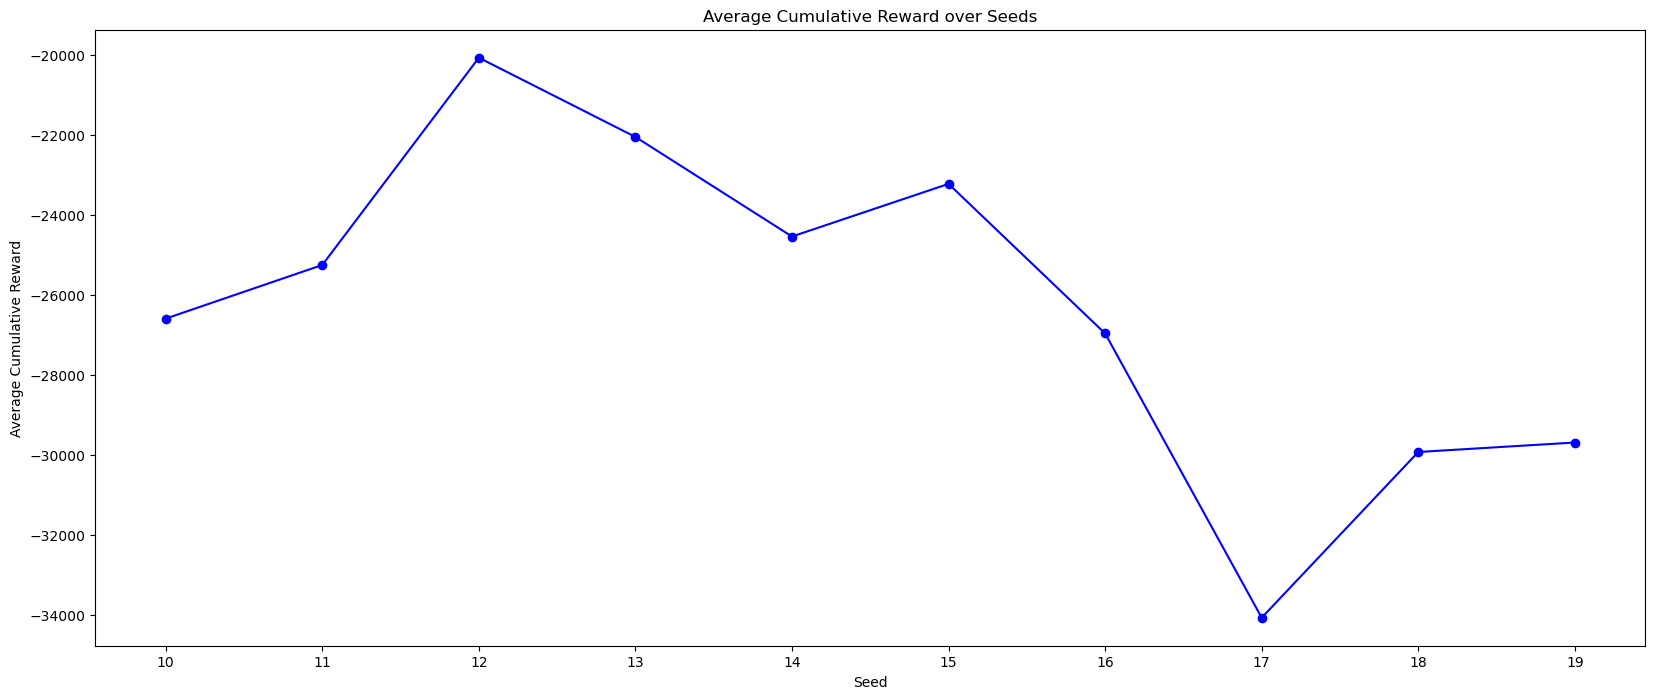

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(range(10, 20), average_reward_Q, marker='o', color='blue', label='Average Cumulative Reward')
plt.title('Average Cumulative Reward over Seeds')
plt.xlabel('Seed')
plt.ylabel('Average Cumulative Reward')
plt.xticks(range(10, 20))
plt.savefig('average_cumulative_reward_over_seeds.png')

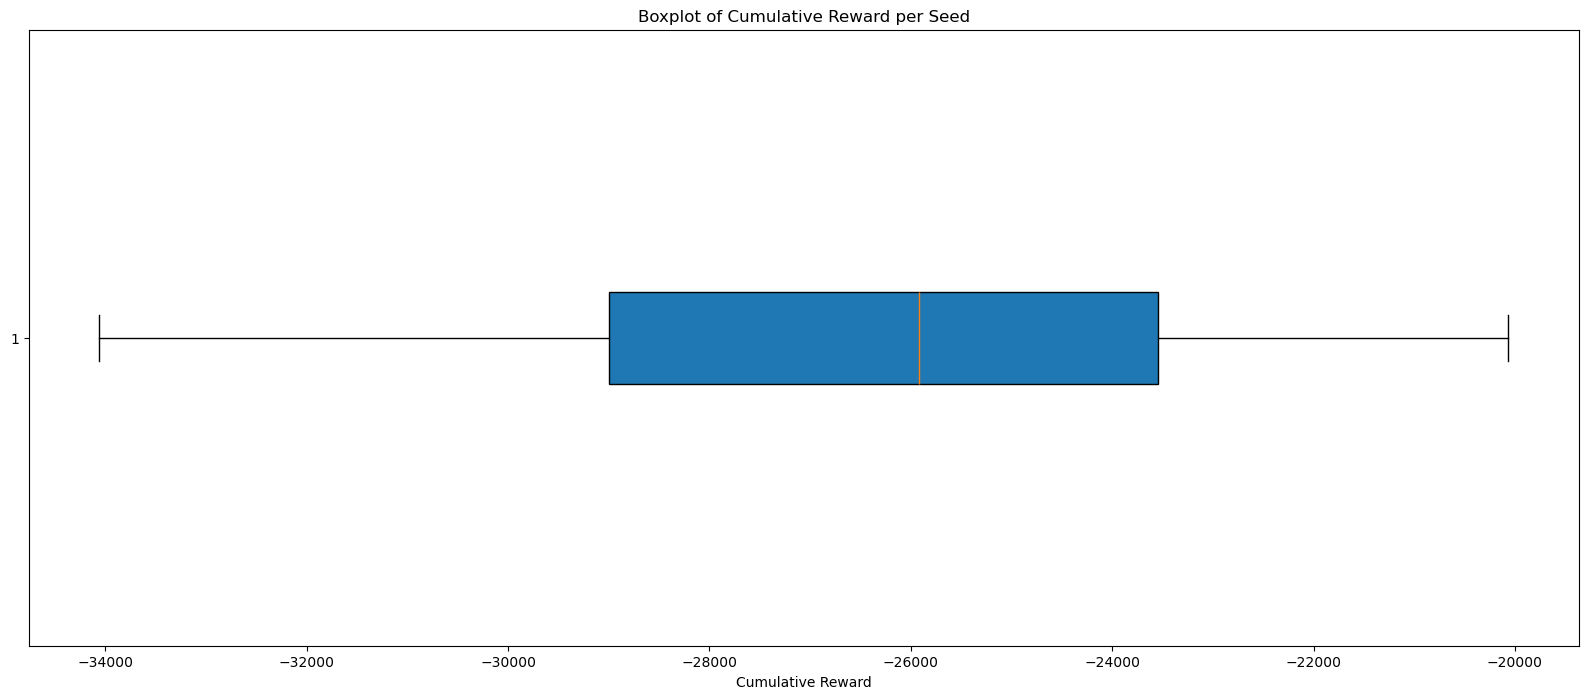

In [ ]:
plt.figure(figsize=(20, 8))
plt.boxplot(average_reward_Q, vert=False, patch_artist=True)
plt.title('Boxplot of Cumulative Reward per Seed')
plt.xlabel('Cumulative Reward')
plt.savefig('boxplot_cumulative_reward_per_seed.png')

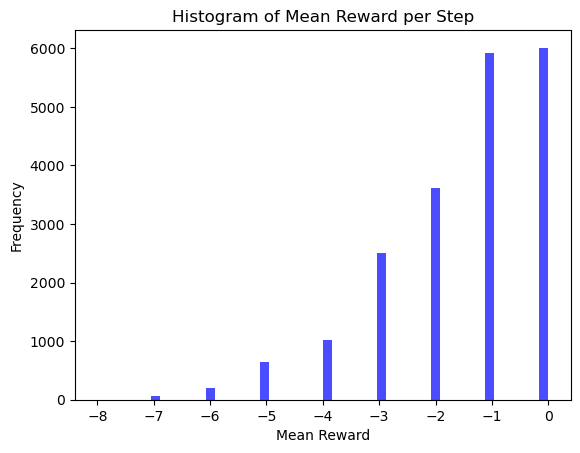

In [ ]:
plt.hist(reward_history_Q, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Mean Reward per Step')
plt.xlabel('Mean Reward')
plt.ylabel('Frequency')
plt.savefig('histogram_mean_reward_per_step.png')

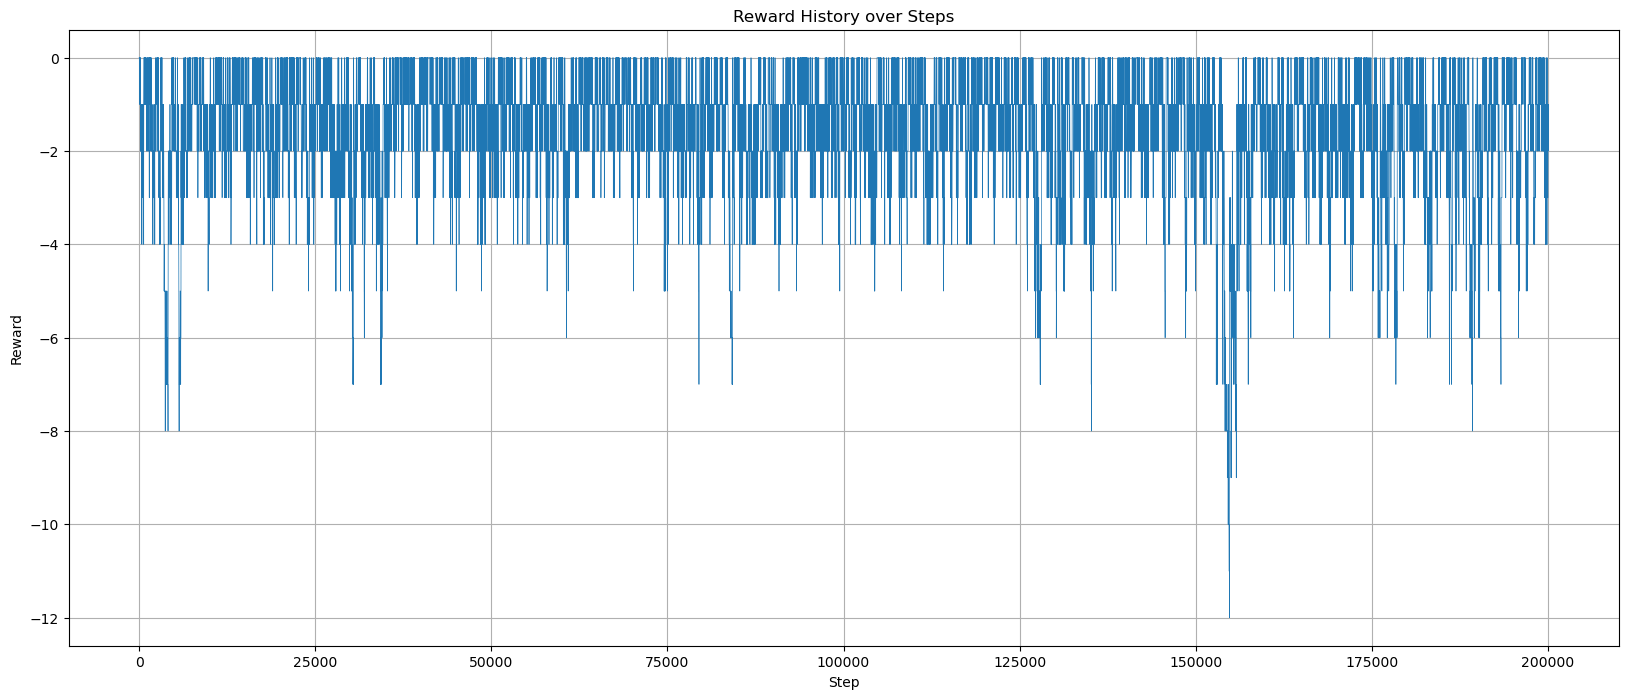

In [ ]:
steps = list(range(len(all_rewards_Q)))

plt.figure(figsize=(20, 8))
plt.plot(steps, all_rewards_Q, linewidth=0.5)
plt.title('Reward History over Steps')
plt.xlabel('Step')
plt.ylabel('Reward')
plt.grid()
plt.savefig('reward_history_over_steps.png')

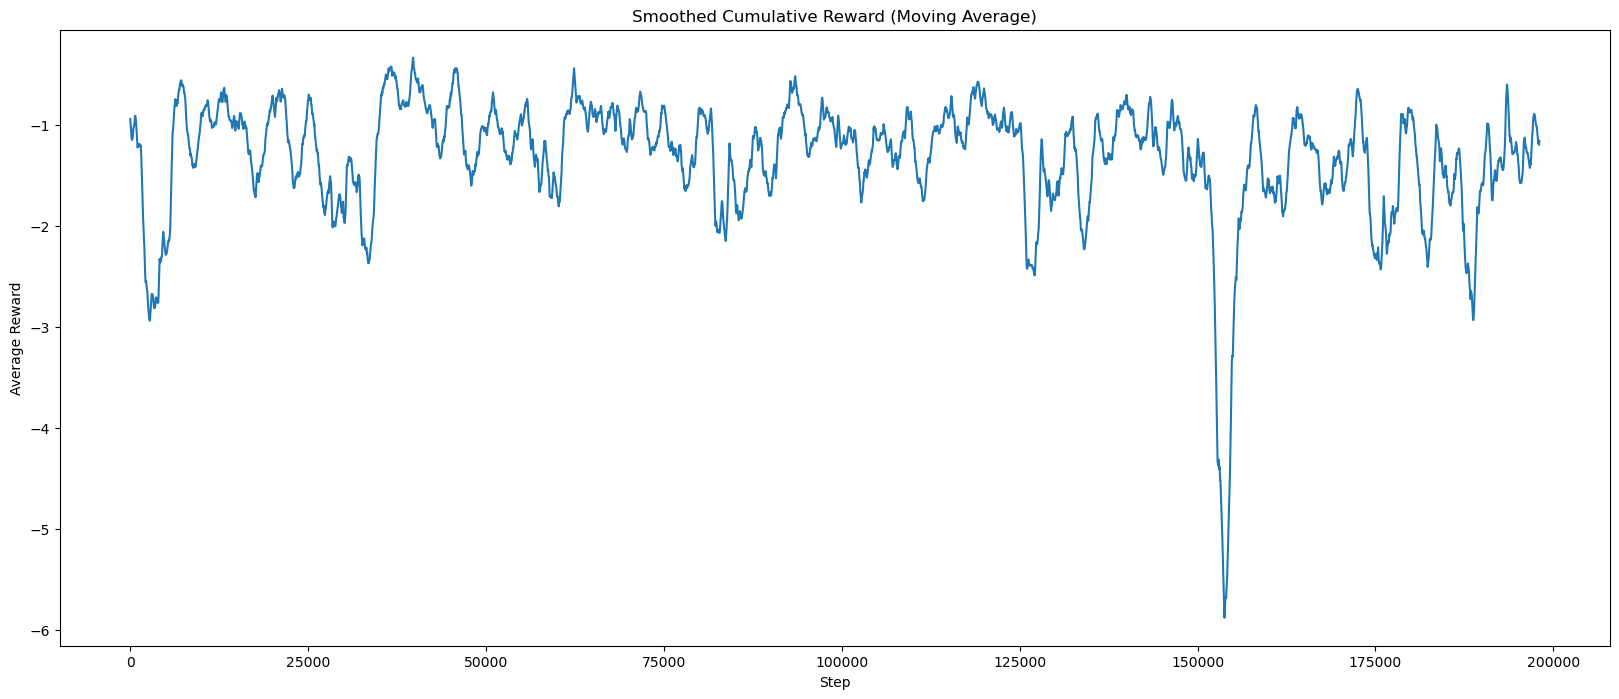

In [ ]:
ma_rewards = moving_average(all_rewards_Q, 2000)

plt.figure(figsize=(20, 8))
plt.plot(ma_rewards)
plt.title("Smoothed Cumulative Reward (Moving Average)")
plt.xlabel("Step")
plt.ylabel("Average Reward")
plt.savefig("smoothed_reward_over_all_steps.png")

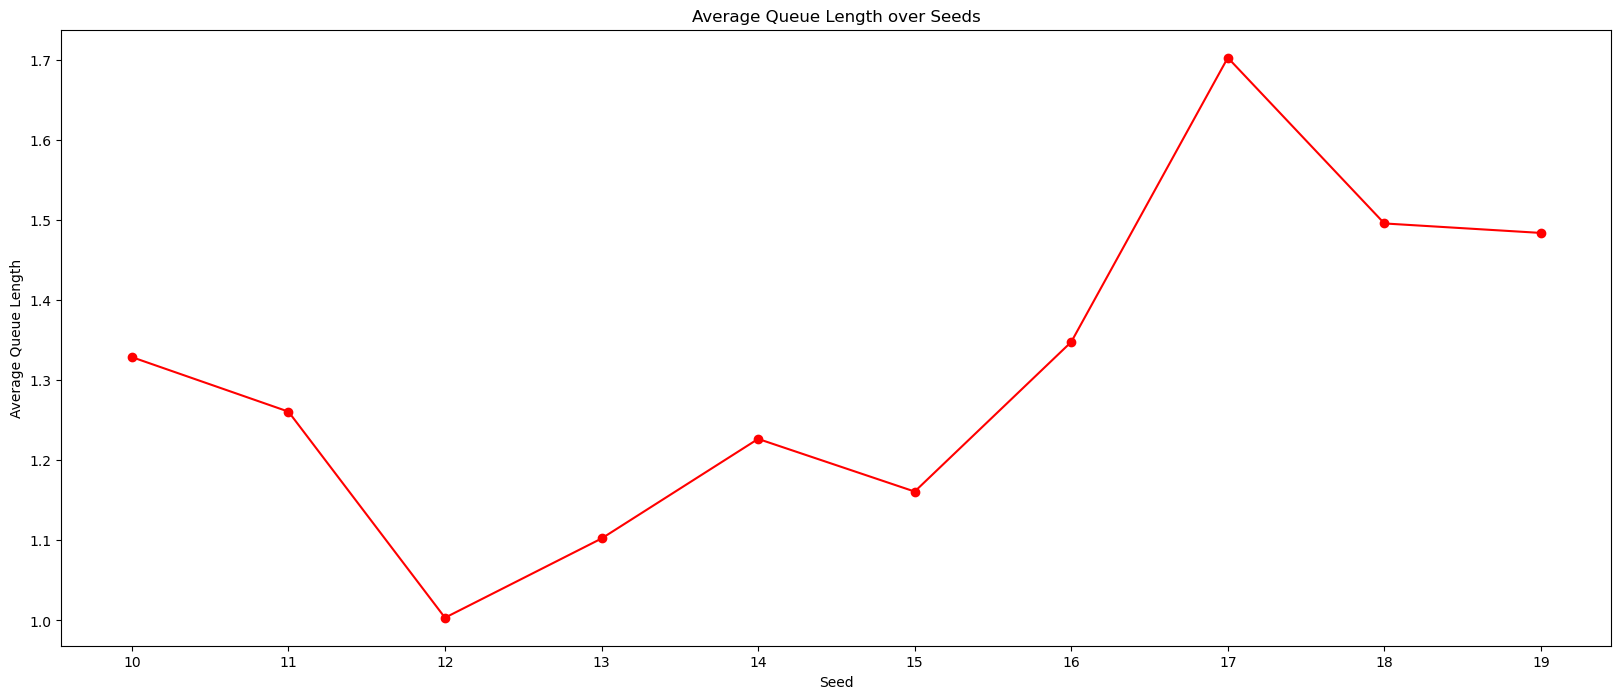

In [35]:
plt.figure(figsize=(20, 8))
plt.plot(range(10, 20), average_queue_length_on_seeds_Q, marker='o', color='red', label='Average Queue Length')
plt.title('Average Queue Length over Seeds')
plt.xlabel('Seed')
plt.ylabel('Average Queue Length')
plt.xticks(range(10, 20))
plt.savefig('average_queue_length_over_seeds.png')

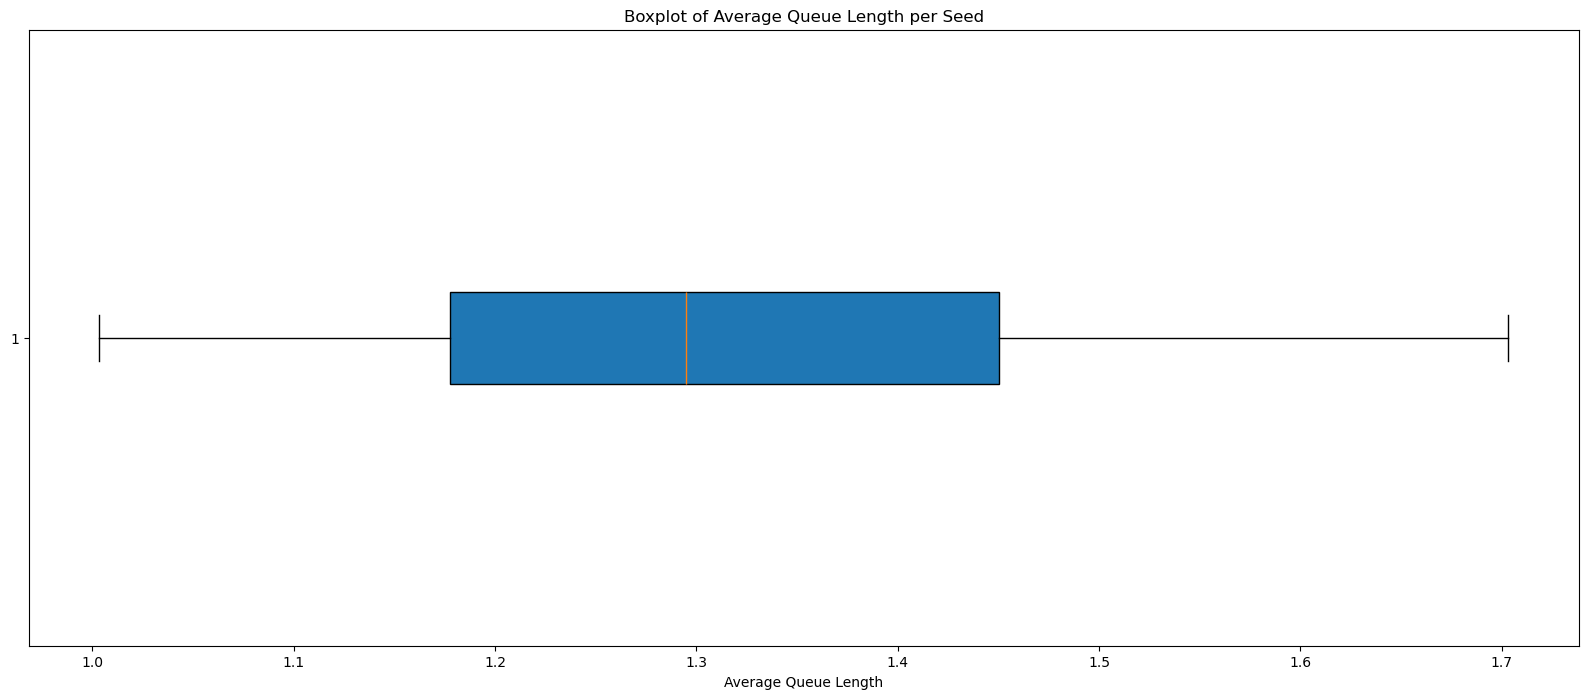

In [ ]:
plt.figure(figsize=(20, 8))
plt.boxplot(average_queue_length_on_seeds_Q, vert=False, patch_artist=True)
plt.title('Boxplot of Average Queue Length per Seed')
plt.xlabel('Average Queue Length')
plt.savefig('boxplot_average_queue_length_per_seed.png')

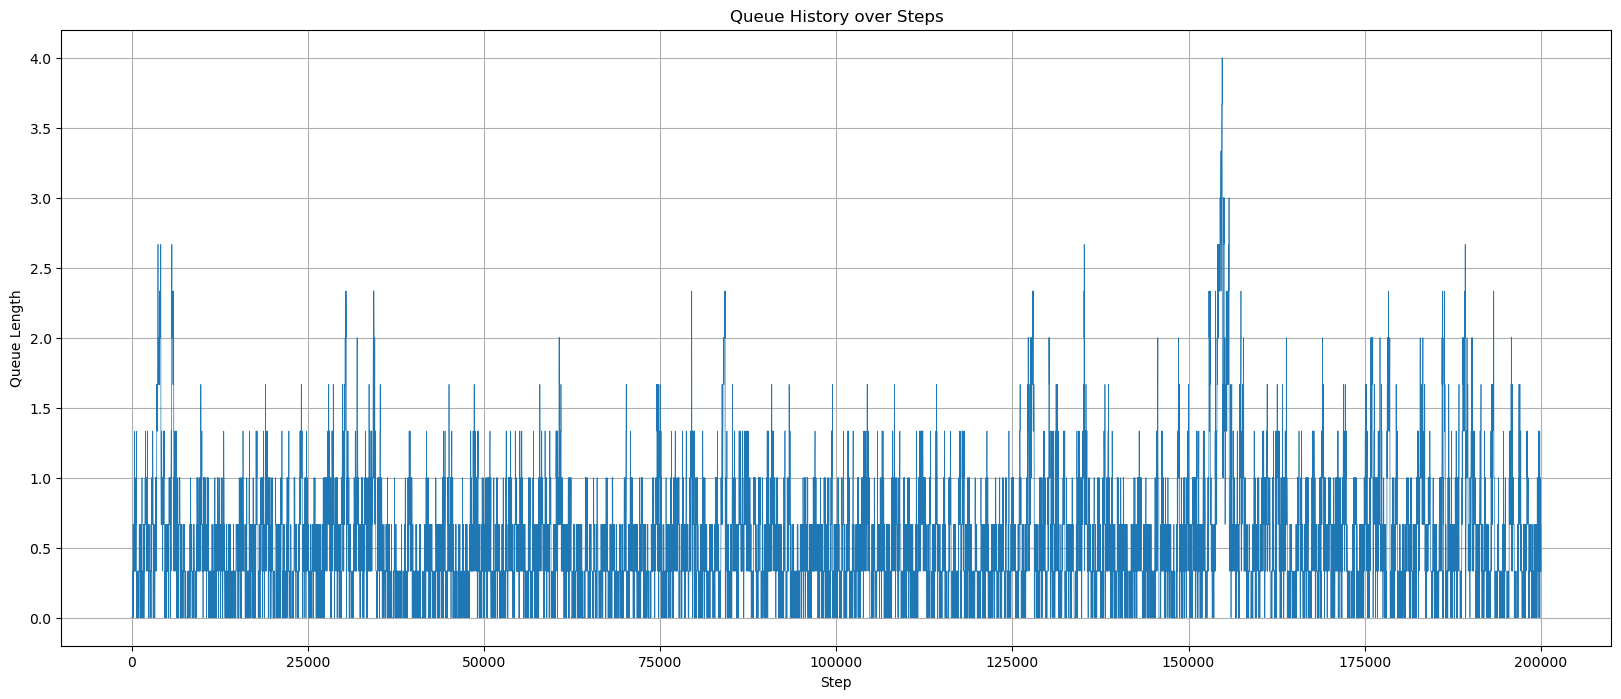

In [ ]:
steps = list(range(len(all_queues_Q)))

plt.figure(figsize=(20, 8))
plt.plot(steps, all_queues_Q, linewidth=0.5)
plt.title('Queue History over Steps')
plt.xlabel('Step')
plt.ylabel('Queue Length')
plt.grid()
plt.savefig('reward_history_over_steps.png')

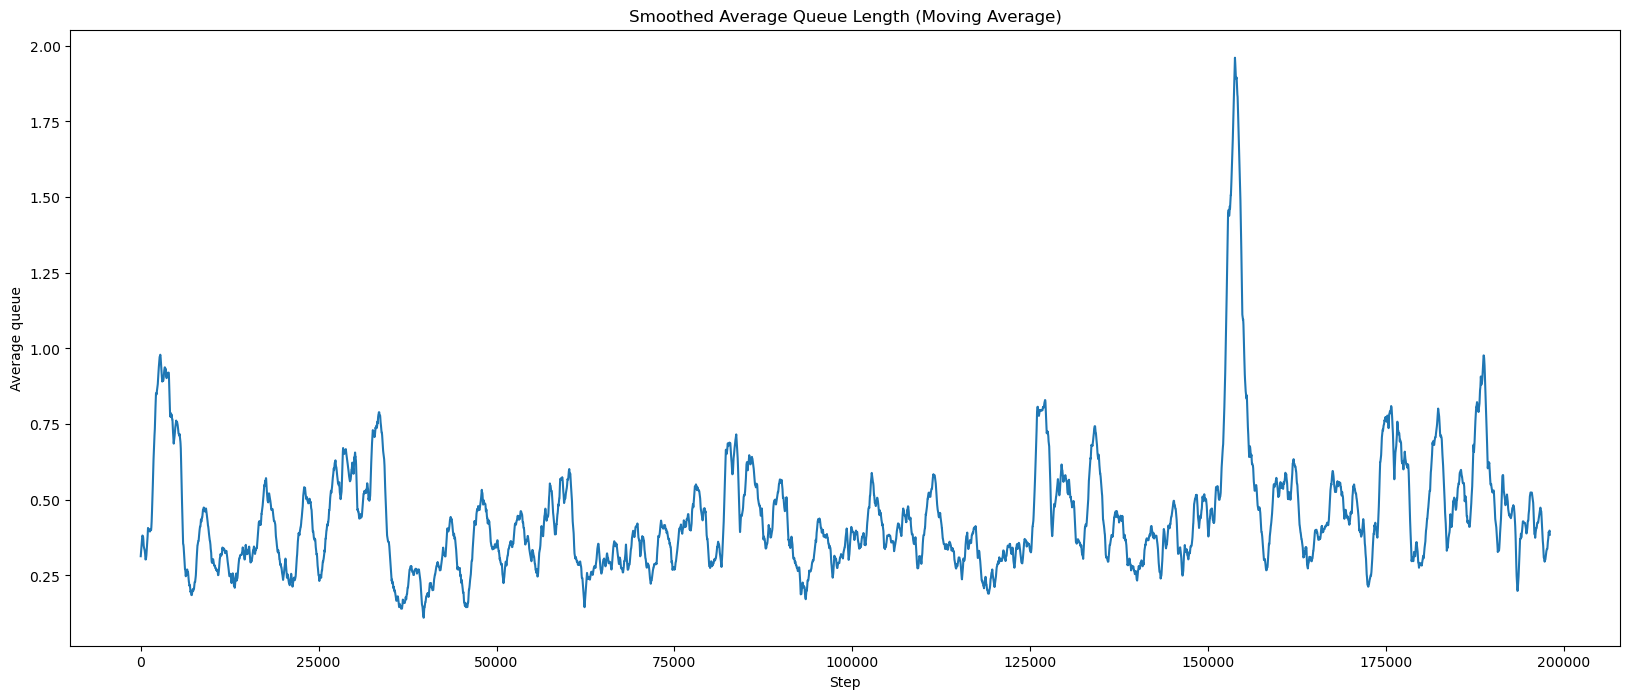

In [ ]:
ma_queues = moving_average(all_queues_Q, 2000)

plt.figure(figsize=(20, 8))
plt.plot(ma_queues)
plt.title("Smoothed Average Queue Length (Moving Average)")
plt.xlabel("Step")
plt.ylabel("Average queue")
plt.savefig("smoothed_reward_over_all_steps.png")

# Comparisons

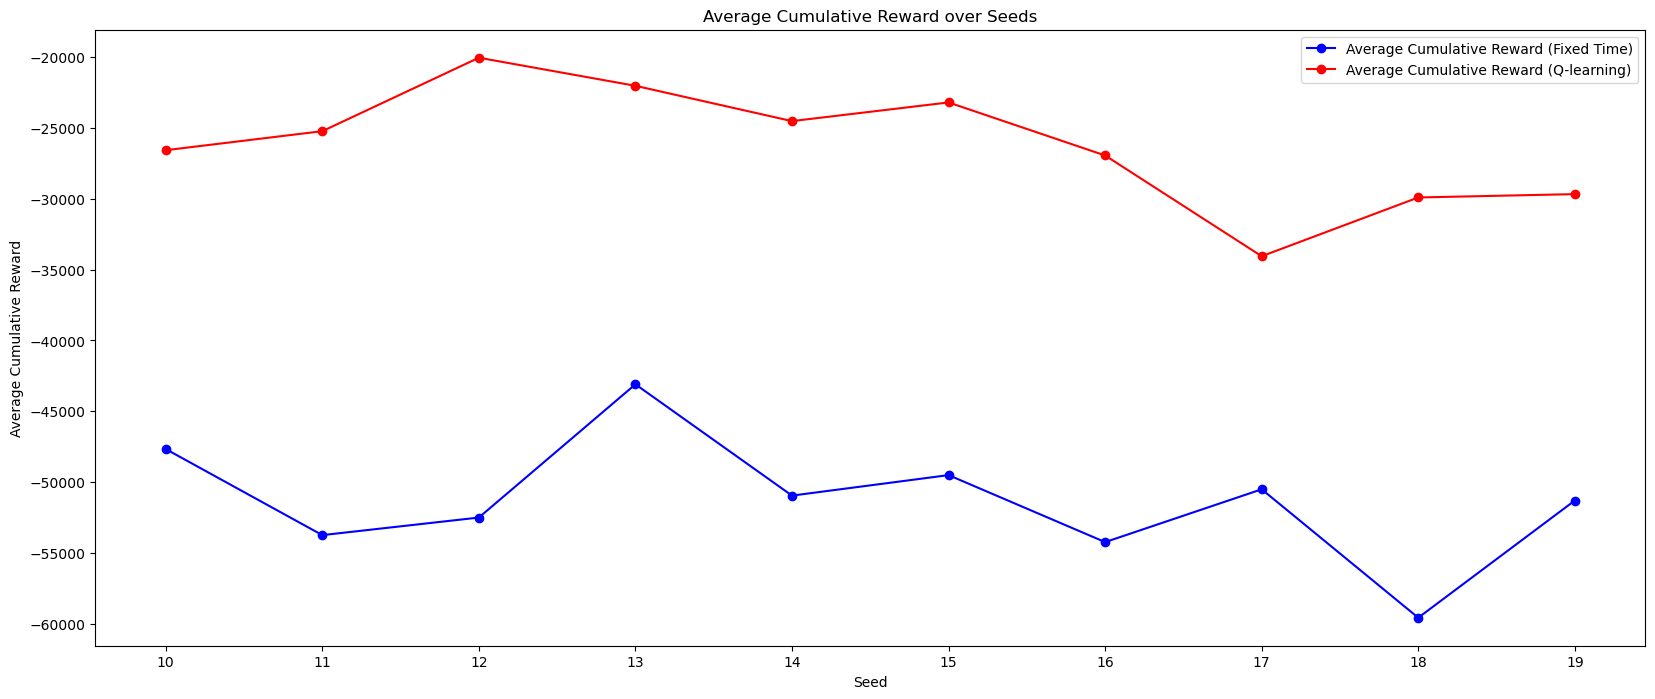

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(range(10, 20), average_reward_FT, marker='o', color='blue', label='Average Cumulative Reward (Fixed Time)')
plt.plot(range(10, 20), average_reward_Q, marker='o', color='red', label='Average Cumulative Reward (Q-learning)')
plt.title('Average Cumulative Reward over Seeds')
plt.xlabel('Seed')
plt.ylabel('Average Cumulative Reward')
plt.xticks(range(10, 20))
plt.legend()
plt.savefig('average_cumulative_reward_comparison.png')

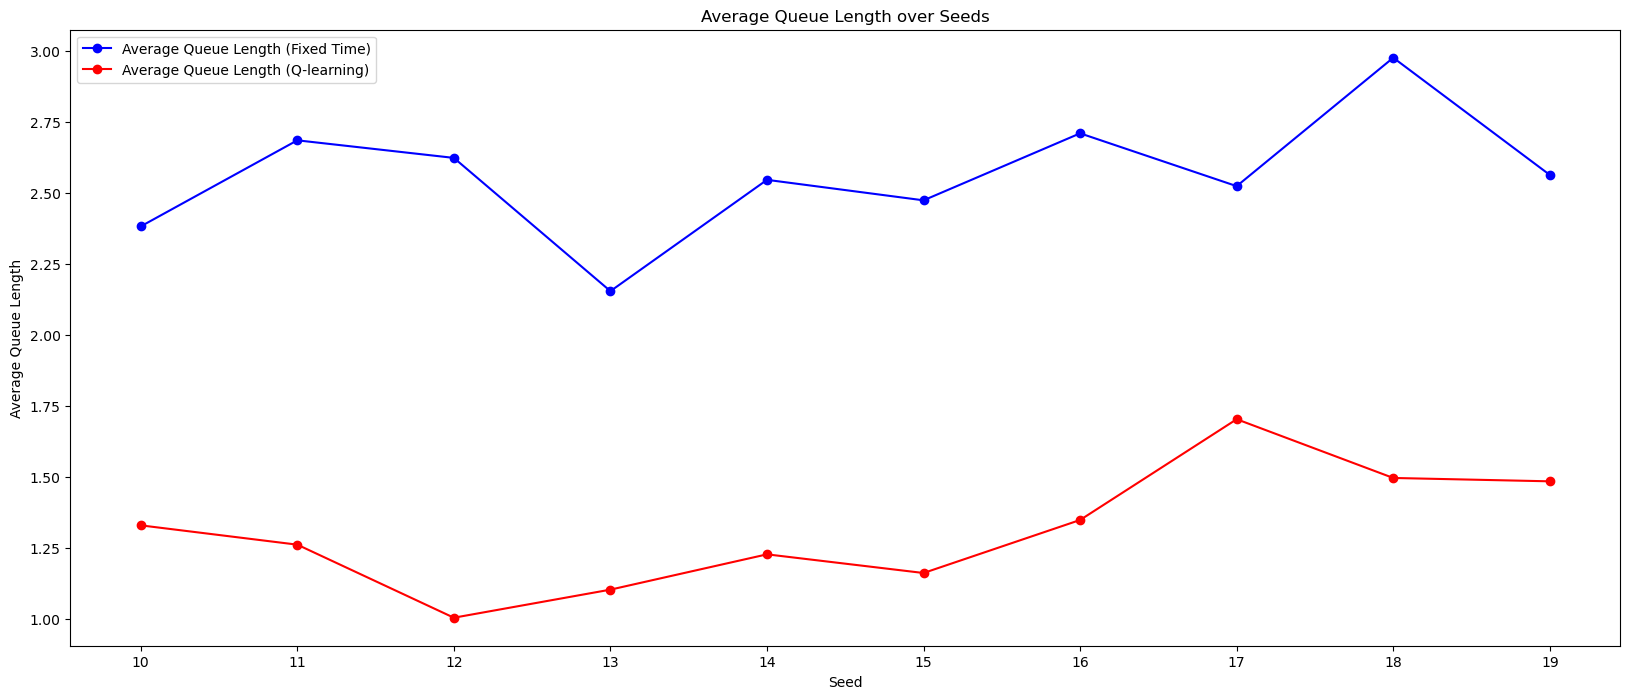

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(range(10, 20), average_queue_length_on_seeds_FT, marker='o', color='blue', label='Average Queue Length (Fixed Time)')
plt.plot(range(10, 20), average_queue_length_on_seeds_Q, marker='o', color='red', label='Average Queue Length (Q-learning)')
plt.title('Average Queue Length over Seeds')
plt.xlabel('Seed')
plt.ylabel('Average Queue Length')
plt.xticks(range(10, 20))
plt.legend()
plt.savefig('average_queue_length_comparison.png')

/var/folders/62/v47sj7tj04gg3ttc76slz9nr0000gn/T/ipykernel_82577/3578444292.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([average_queue_length_on_seeds_FT, average_queue_length_on_seeds_Q], vert=False, patch_artist=True, labels=['Fixed Time', 'Q-learning'])


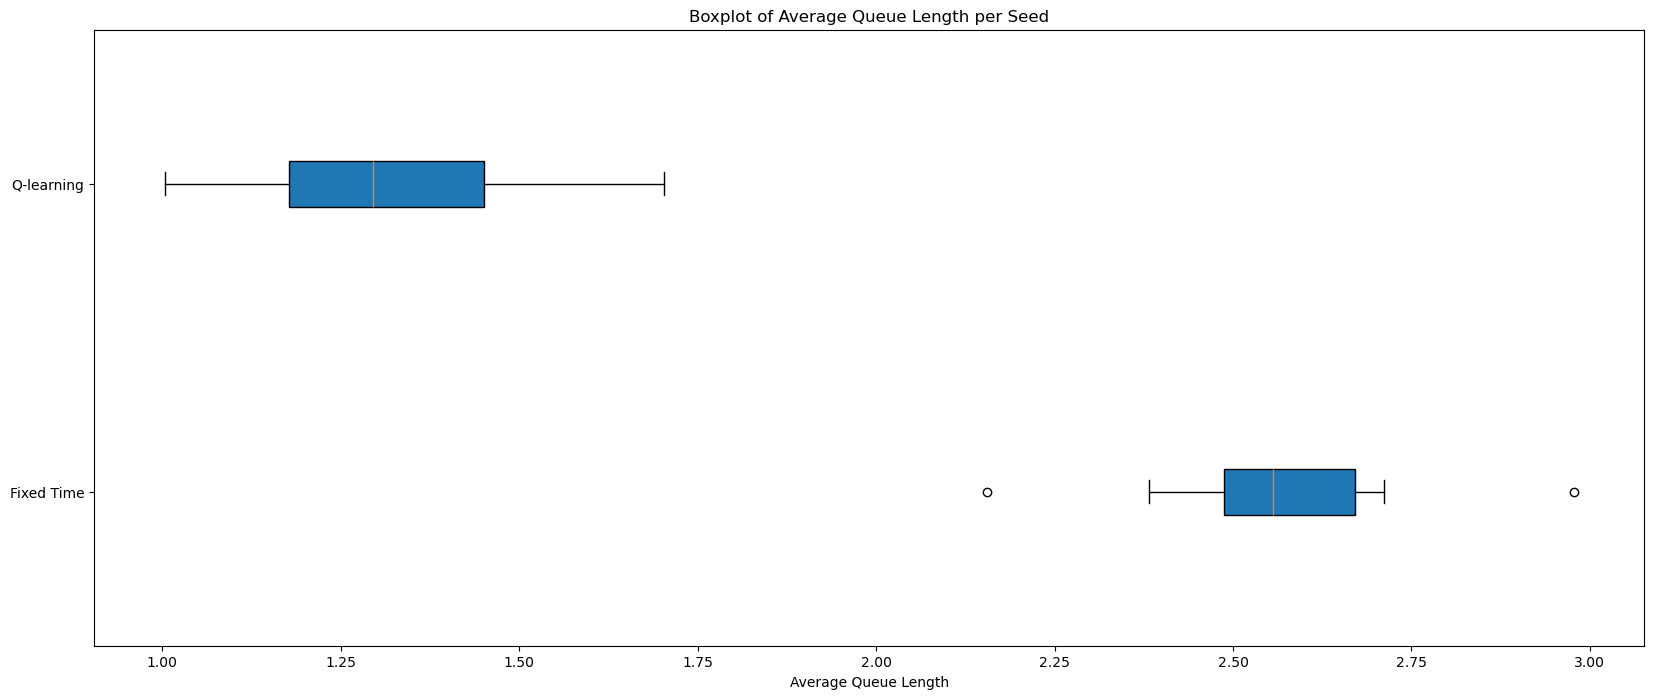

In [ ]:
plt.figure(figsize=(20, 8))
plt.boxplot([average_queue_length_on_seeds_FT, average_queue_length_on_seeds_Q], vert=False, patch_artist=True, labels=['Fixed Time', 'Q-learning'])
plt.title('Boxplot of Average Queue Length per Seed')
plt.xlabel('Average Queue Length')
plt.savefig('boxplot_average_queue_length_comparison.png')

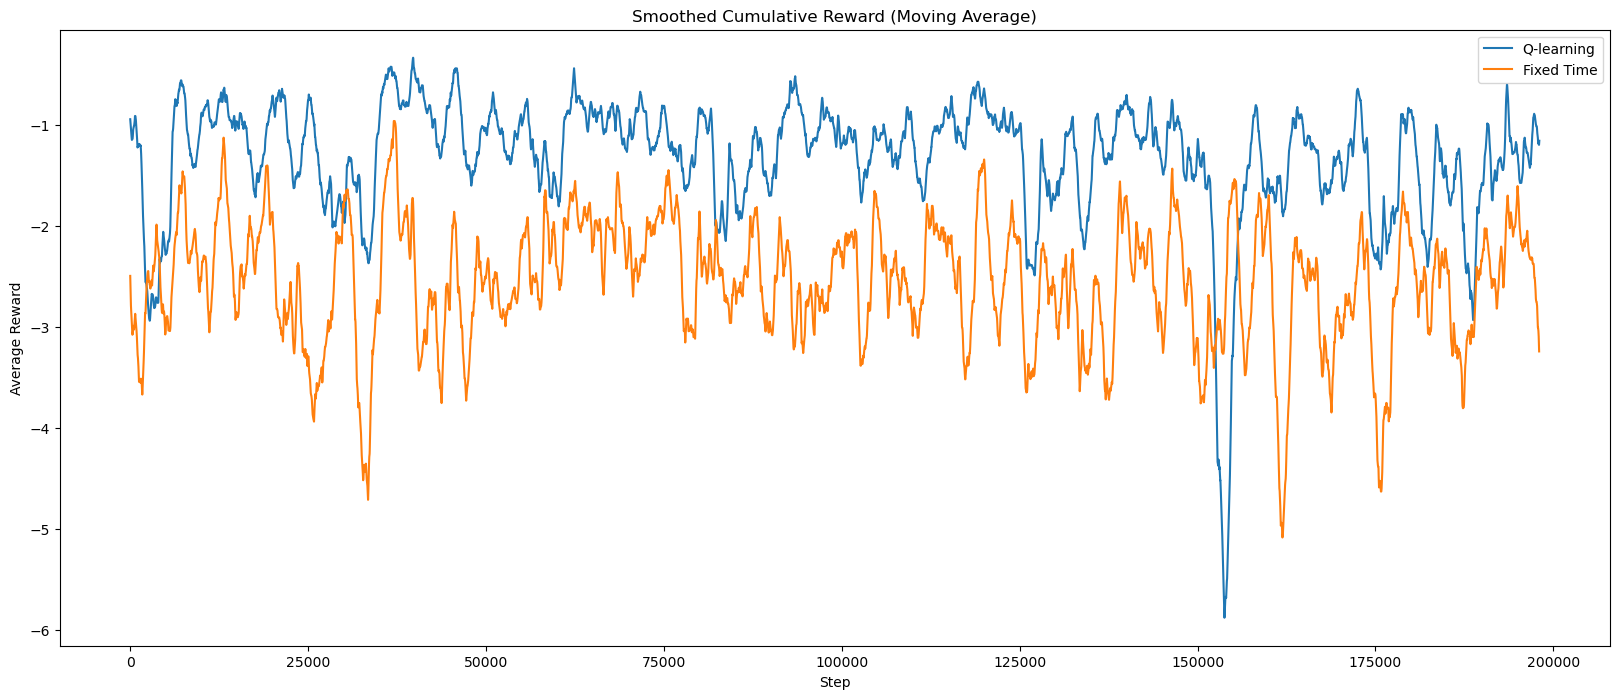

In [ ]:
ma_rewards_Q = moving_average(all_rewards_Q, 2000)
ma_rewards_FT = moving_average(all_rewards_FT, 2000)

plt.figure(figsize=(20, 8))
plt.plot(ma_rewards_Q, label='Q-learning')
plt.plot(ma_rewards_FT, label='Fixed Time')
plt.title("Smoothed Cumulative Reward (Moving Average)")
plt.xlabel("Step")
plt.ylabel("Average Reward")
plt.legend()
plt.savefig("smoothed_reward_comparison.png")

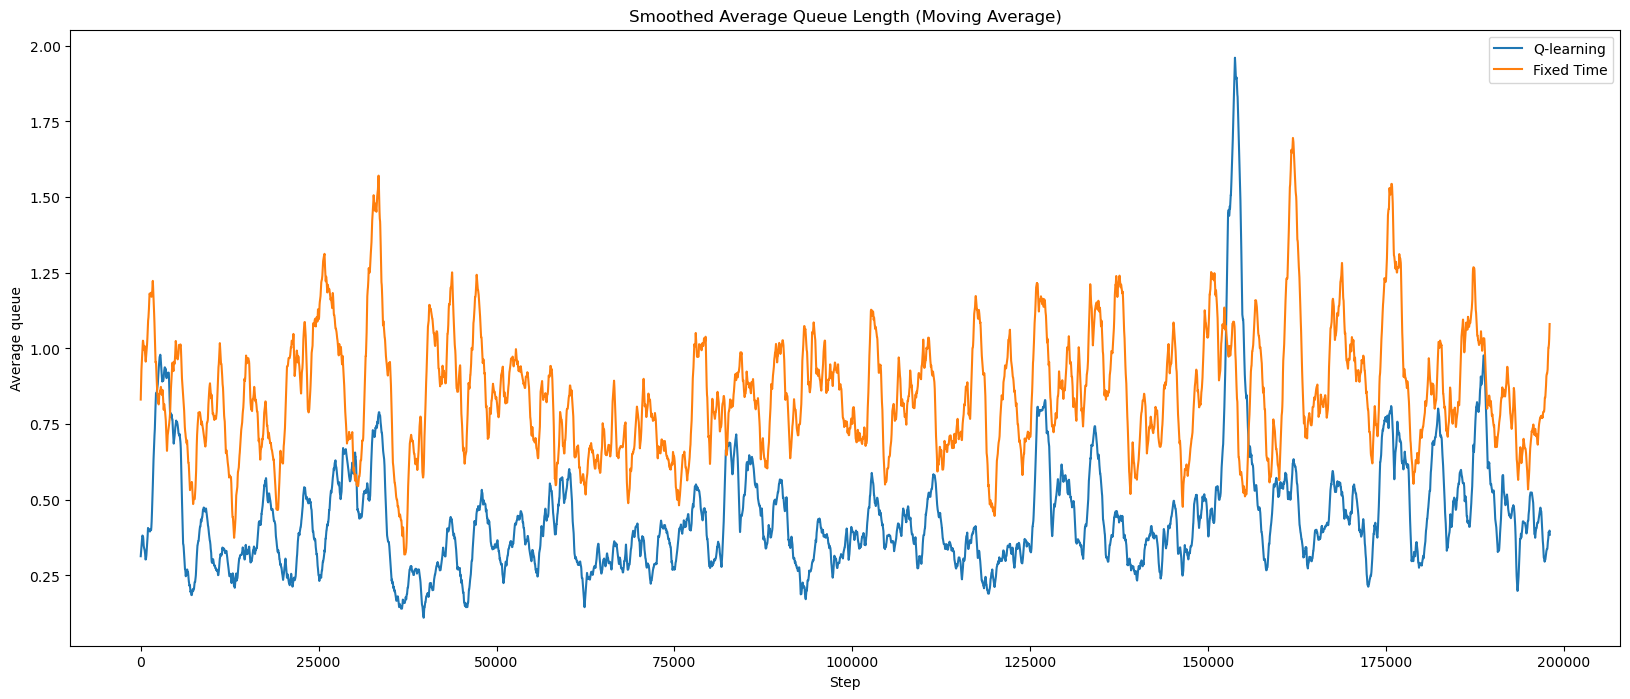

In [ ]:
ma_queues_Q = moving_average(all_queues_Q, 2000)
ma_queues_FT = moving_average(all_queues_FT, 2000)

plt.figure(figsize=(20, 8))
plt.plot(ma_queues_Q, label='Q-learning')
plt.plot(ma_queues_FT, label='Fixed Time')
plt.title("Smoothed Average Queue Length (Moving Average)")
plt.xlabel("Step")
plt.ylabel("Average queue")
plt.legend()
plt.savefig("smoothed_queue_comparison.png")